<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/practica_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 5: Inferencia computacional

En la clase pasada vimos cómo adoptando un modelo de generación de los datos observados y una función de distribución a priori de los parámetros de ese modelo pudimos obtener, dado un dataset, las funciones de distribución a posterior de los parámetros así como una función de distribución predictiva de nuevos datos.

En esta clase vamos a repetir el procedimiento pero ya no usando soluciones analíticas (¡no siempre existen!), sino que vamos a ver diferentes métodos numéricos: la aproximación por grilla (integración numérica), la aproximación cuadrática, y mediante simulación con método de Monte Carlo via Cadenas de Markov (MCMC).

In [1]:
!pip install pymc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import statsmodels.api as sm
from scipy.interpolate import interp1d
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.interpolate
from scipy.optimize import minimize
import io
import pymc as pm
import arviz as az

##Ejemplo 1: El Ejemplo 1 de la Clase 4
Para empezar, tomemos un ejercicio sencillo como es el ajuste de los parámetros de los datos provenientes de ensayos de probetas de hormigón. Vimos la otra vez que asumiendo que los datos fueron generados por modelo normal

$$ y_i \sim N \left( \mu, \sigma^2 \right) $$

Con una distribución a priori no-informativa,

$$p(\mu,\sigma^{2}) \propto \left( \sigma^2 \right)^{-1}$$

Teníamos la solución analítica para la distribución posterior de los parámetros

$$\mu | \mathbf{y} \sim t_{N-1}\left(\bar{y},s\sqrt{\frac{1}{N}}\right)$$

$$\sigma^{2} | \mathbf{y} \sim Inv-Gamma\left(\frac{N-1}{2},\frac{\left(N-1\right)s^{2}}{2}\right)$$

donde $\bar{y}$ era la media de las observaciones, $N$ el número de muestras y $s$ el desvío muestral. Y también teníamos la función predictiva:

$$\tilde{y}| \mathbf{y} \sim t_{N-1}\left(\bar{y},s\sqrt{1+\frac{1}{N}}\right)$$

In [4]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving ProbetasHormigon.csv to ProbetasHormigon (1).csv


In [5]:
#Se crea un DataFrame
df_probetas = pd.read_csv(io.BytesIO(uploaded['ProbetasHormigon.csv']))
df_probetas.head()

,Ensayo,Resistencia (MPa),Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,1,33.3,NaN,NaN,NaN,NaN
1,2,37.4,NaN,NaN,NaN,NaN
2,3,36.5,NaN,NaN,NaN,NaN
3,4,32.3,NaN,NaN,NaN,NaN
4,5,37.4,NaN,NaN,NaN,NaN


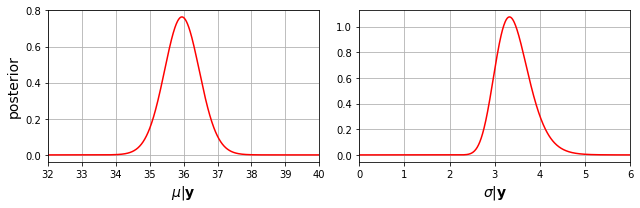

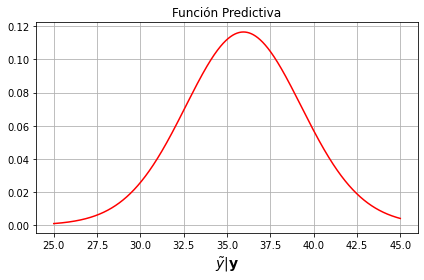

In [6]:
# Inferencia
N = len(df_probetas['Resistencia (MPa)'])
muy = df_probetas['Resistencia (MPa)'].mean()
sy = df_probetas['Resistencia (MPa)'].std()

# Posterior marginal de mu
mu_post = st.t( N-1, loc=muy, scale=sy*np.sqrt(1/N))

# Posterior marginal de sigma2
s2_post = st.invgamma( (N-1)/2, loc=0, scale=(N-1)*sy**2/2 )

# Posterior de nuevas observaciones
y_post = st.t( N-1, loc=muy, scale=sy*np.sqrt(1+1/N))

# Plot
x=np.linspace(0,40,4001)
fig, ax = plt.subplots( figsize=(9,3), nrows=1, ncols=2 )
ax[0].plot(x, mu_post.pdf(x), color='r')
ax[0].set_xlabel(r'$\mu | \mathbf{y}$', fontsize=14)
ax[0].set_ylabel('posterior', fontsize=14)
ax[0].set_xlim([32,40])
ax[0].grid()

ax[1].plot(x, 2*x*s2_post.pdf(x**2), color='r')
ax[1].set_xlabel(r'$\sigma | \mathbf{y}$', fontsize=14)
#ax[1].set_ylabel('posterior', fontsize=14)
ax[1].set_xlim([0,6])
ax[1].grid()

fig.tight_layout()
plt.show()

# Plot
x = np.linspace(25,45,4001)
fig = plt.figure( figsize=(6,4))
plt.plot(x, y_post.pdf(x), color='r',label='Bayes')
plt.xlabel(r'$\tilde{y} | \mathbf{y}$', fontsize=14)
plt.grid()
plt.title('Función Predictiva')

fig.tight_layout()
plt.show()

Hasta acá nada nuevo. Veamos entonces cómo se aplican las otras metodologías, que luego nos serán muy útiles para la gran mayoría de problemas que no tienen una solución cerrada.

###Solución mediante integración numérica.

Recordando, la distribución a posterior de los parámetros se calculaba como:

$$p(\mu, \sigma | \mathbf{y}) = \frac{p(\mathbf{y} | \mu, \sigma)\ p(\mu, \sigma)}{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}p(\mathbf{y} | \mu, \sigma)\ p(\mu, \sigma)\ d \mu\ d \sigma}$$

$$p(\mu, \sigma | \mathbf{y}) = C\ p(\mathbf{y} | \mu, \sigma)\ p(\mu, \sigma)$$

La mayor complejidad esta en el cálculo de la integral del denominador, que no es más que un factor de escala para que el producto entre la función de verosimilitud y la distribución a priori cumpla los requisitos de una función de distribución (que el área bajo la curva de 1).

Lo que vamos a hacer, entonces, es calcular $C$ en forma numérica (generando una grilla de valores de $\mu, \sigma$)

####Paso 1: Definir la función a priori

En este caso, dijimos que vamos a usar una versión no informativa:

$$p(\mu,\sigma) \propto \sigma^{-1}$$

No hace falta especificar la constante porque 1. tiende a 0 analíticamente y 2. A fin de cuentas vamos a encontrar la constante de la función a posteriori así que no afectaría el resultado final.

In [7]:
# Función a priori (no-informativa)
def prior( x, y ):
    return np.ones( x.shape)*y**(-1)

####Paso 2: Definir la función de verosimilitud

En este ejemplo es muy sencillo, la función de verosimilitud asumiendo que los ensayos son independientes y normalmente distribuidos va a ser:

$$p(\mathbf{y} | \mu, \sigma) = \prod_{i=1}^{N} p(y_{i}|\mu, \sigma)$$

donde $p(y_{i}|\mu, \sigma)$ no es más que el modelo de generación de datos, es decir el valor que toma la función de distribución de una variable normal evaluada con $y_{i}$ y los parámetros $\mu, \sigma$

$$ y_i \sim N \left( \mu, \sigma^2 \right) $$

En Python, es más fácil calcular la sumatoria de los logaritmos y luego calcular la exponencial.

$$log\ p(\mathbf{y} | \mu, \sigma) = \sum_{i=1}^{N} log\ p(y_{i}|\mu, \sigma)$$

$$p(\mathbf{y} | \mu, \sigma) = e^{log\ p(\mathbf{y} | \mu, \sigma)}$$




In [8]:
# Función de verosimilitud (función de x, y, en base a los datos)
def likelihood( data, x, y ):
    l = np.zeros( x.shape )
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            l[i,j] = np.sum( st.norm.logpdf( data, loc=x[i,j], scale=y[i,j] ) )
    return np.exp(l)

####Paso 3: Integrar numéricamente

Ya estamos en condiciones de obtener la constante $C$ numéricamente. Primero, nos generamos una grilla de valores de $\mu, \sigma$ en los que evaluaremos la funciones para integrar:

In [9]:
# Definir grilla (paso de discretización)
dx = 0.05
dy = 0.05

# Definir grilla (limites)
xmin = 33.5
xmax = 38.5
ymin = 1
ymax = 6

# Vectores
xvec = np.arange(xmin,xmax,dx)
yvec = np.arange(ymin,ymax,dy)

xgrid, ygrid = np.meshgrid( xvec, yvec )

SI la grilla es suficientemente densa y extensa en rango nos pareceremos cada vez más a la solución real (tendremos como contrapartida el tiempo de ejecución). Siempre es bueno hacer una estimación del error en la integral (comparando contra una discretización más fina y extendiendo los límites)

Luego, evaluamos nuestra función de verosimilitud y nuestra función a priori en los valores de la grilla:

In [10]:
# Definir priori
prior_grid = prior( xgrid, ygrid )

# Calcular verosimilitud
likelihood_grid = likelihood( df_probetas['Resistencia (MPa)'], xgrid, ygrid )

Y finalmente obtenemos la distribución a posteriori de los parámetros en forma numérica:

In [11]:
# Calcular constante C
unstd_posterior = likelihood_grid * prior_grid
C = 1/(unstd_posterior.sum()*dx*dy)

# Definir función posterior
posterior = C*unstd_posterior

¡Y ya está! podemos graficar las distribuciones conjuntas.

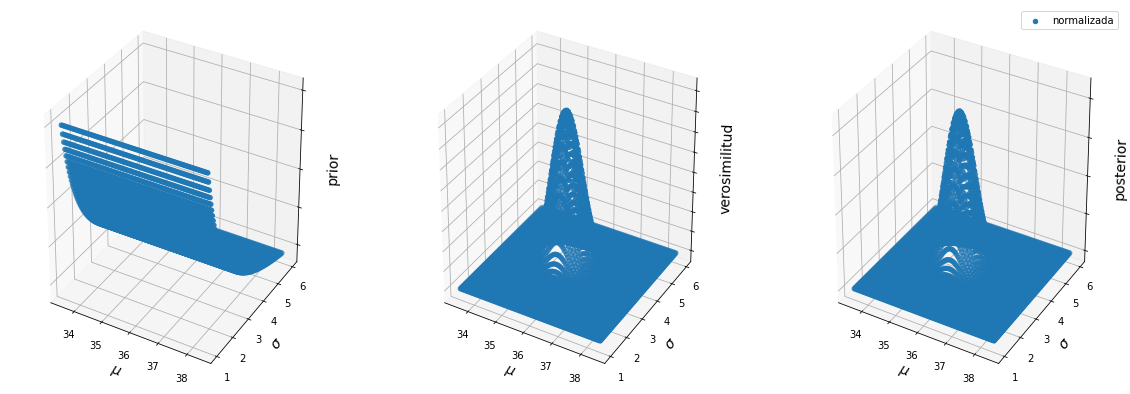

In [12]:
# Plot
fig = plt.figure( figsize=(20,7) )

ax = fig.add_subplot( 1, 3, 1, projection='3d' )
ax.scatter( xgrid, ygrid, prior_grid )
ax.set_xlabel(r'$\mu$', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('prior', fontsize=14)
ax.set_zticklabels([])

ax = fig.add_subplot( 1, 3, 2, projection='3d' )
ax.scatter( xgrid, ygrid, likelihood_grid )
ax.set_xlabel(r'$\mu$', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('verosimilitud', fontsize=14)
ax.set_zticklabels([])

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter( xgrid, ygrid, posterior, label='normalizada')
ax.set_xlabel(r'$\mu$', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('posterior', fontsize=14)
ax.set_zticklabels([])
ax.legend();

Y obtener (también por integración numérica) las distribuciones marginales de $\mu, \sigma$.

In [13]:
# Distribución marginal de mu
mu_num = np.sum(posterior,axis=0)*dy

# Distribución marginal de sigma
s_num = np.sum(posterior,axis=1)*dx

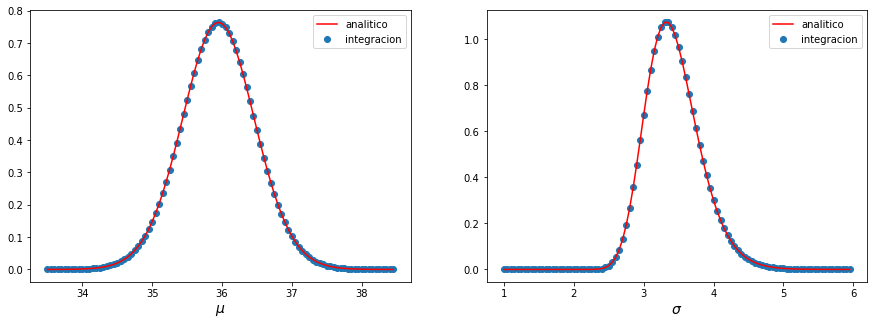

In [14]:
# Plot
fig = plt.figure( figsize=(15,5) )

ax = fig.add_subplot( 1, 2, 1)
ax.scatter( xvec, mu_num,label='integracion')
ax.plot(xvec,mu_post.pdf(xvec),'r-',label='analitico')
ax.set_xlabel(r'$\mu$', fontsize=14)
ax.legend(loc=0)

ax = fig.add_subplot( 1, 2, 2)
ax.scatter( yvec, s_num,label='integracion')
ax.plot(yvec,2*yvec*s2_post.pdf(yvec**2),'r-',label='analitico')
ax.set_xlabel(r'$\sigma$', fontsize=14)
ax.legend(loc=0)
plt.show()


Fijensé que llegamos a exactamente lo mismo.

Para poder realizar una simulación de Monte Carlo en lo que sigue después, vamos a necesitar en realidad la función de distribución de $\mu$ condicionada al valor de $\sigma$. Esta sabemos analíticamente que es:

$$p(\mu|\bar{\sigma},\mathbf{y}) = \frac{p(\mu,\sigma = \bar{\sigma} | \mathbf{y})}{p(\sigma=\bar{\sigma}|\mathbf{y})}$$

¡Todos los datos para hacer esto numéricamente los tenemos ya! Simplemente hacemos:

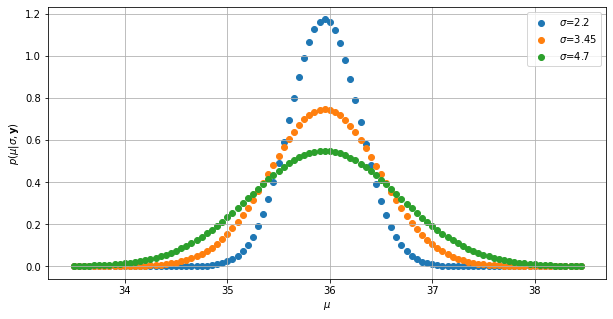

In [15]:
# Función de distirbución de mu condicionada a sigma
mu_cond_num = posterior / np.reshape(s_num,(-1,1))

# plot
fig = plt.figure(figsize=(10,5))
for x in [24,49,74]:
  plt.scatter(xvec,mu_cond_num[x,:],label=r'$\sigma$={}'.format(round(yvec[x],2)))
  plt.legend()
  plt.xlabel(r'$\mu$')
  plt.ylabel(r'$p(\mu|\sigma,\mathbf{y})$')
  plt.grid()
plt.show()

#####NOTA ANEXA: ¿Función predictiva por integración? Y su aplicación (Ver por su cuenta)

Del mismo modo, podríamos obtener la función de distribución de la predictiva recordando que

$$p(\tilde{y}| \mathbf{y}) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} p(\tilde{y} | \mu, \sigma)\ p(\mu,\sigma|\mathbf{y})\ d\mu\ d\sigma$$

que es una integral que también podemos resolver en forma numérica (para cada valor de $\tilde{y}$, lo que va a ser que este proceso sea computacionalmente intenso (y lento).

In [16]:
# Funcion predictiva
def predictive( posterior, x, y, dx, dy, z):
    m = np.zeros( z.shape )
    for k in range( z.shape[0]):
      l = np.zeros( x.shape )
      for i in range(x.shape[0]):
          for j in range(x.shape[1]):
              l[i,j] = st.norm.pdf( z[k], loc=x[i,j], scale=y[i,j] )
      Temp = posterior*l
      m[k] = Temp.sum()*dx*dy
    return m

In [17]:
# Ecuación predictiva
dytilde = 0.5
ytilde = np.arange(25,45,dytilde)
y_pred = predictive( posterior, xgrid, ygrid, dx, dy, ytilde)

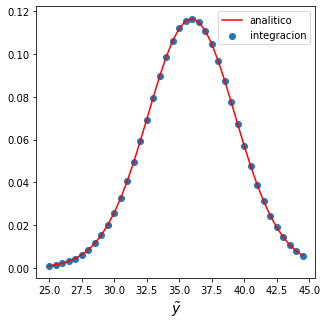

In [18]:
# Plot
fig = plt.figure( figsize=(5,5) )

plt.scatter( ytilde, y_pred,label='integracion')
plt.plot(ytilde,y_post.pdf(ytilde),'r-',label='analitico')
plt.xlabel(r'$\tilde{y}$', fontsize=14)
plt.legend(loc=0)
plt.show()

Y, por ejemplo, si quisiera obetener la resistencia característica del hormigón tendría que

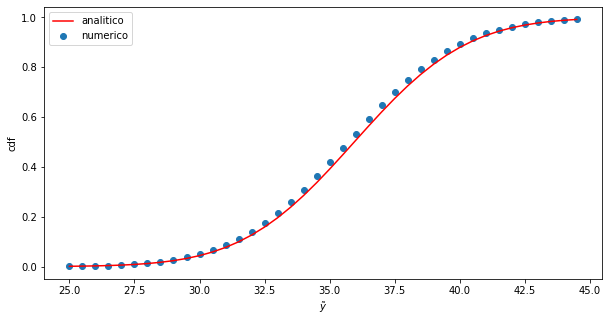

In [19]:
# Resistencia característica

# CDF numérica (por integración)
CDF = np.cumsum(y_pred)*dytilde

fig = plt.figure(figsize=(10,5))
plt.scatter(ytilde,CDF,label='numerico')
plt.plot(ytilde,y_post.cdf(ytilde),'r-',label='analitico')
plt.legend(loc=0)
plt.xlabel(r'$\tilde{y}$')
plt.ylabel(r'cdf')
plt.show()

In [20]:
fc = max(ytilde[CDF<=0.1])
print('la resistencia caracteristica es',fc,'MPa')
print('la solución analítica era',y_post.ppf(0.1),'MPa')

la resistencia caracteristica es 31.0 MPa
la solución analítica era 31.513201646505706 MPa


Sin embargo, en la práctica este paso no es muy útil, y una vez que se tienen las distribuciones posteriores se procede directamente a la evaluación de la predicción a partir de la simulación. Fijensé que con esta forma de resolverlo solo tengo saltos discretos de 0.5MPa, lo cual limita los valores, y a su vez el proceso es bastante lento...

Por eso esto no lo vamos a hacer, sino que vamos directamente a la simulación.

####Paso 4: Predicción mediante el método de Monte Carlo (Ver por su cuenta)
Ya con las funciones de distribución (obtenidas por integración numérica), podemos hacer uso de la simulación con Monte Carlo para realizar predicciones sobre $\tilde{y}$. Eso nos permitirá evaluar el modelo contra los datos y hacer después los análisis que necesitemos (como obtener la resistencia característica del hormigón).

Los pasos a seguir para la simulación de Monte Carlo en este ejercicio son los siguientes.

1.   Construir la función de probabilidad acumulada de $\sigma|\mathbf{y}$
2.   Simular $N\times 3$ números aleatorios con una distribución uniforme entre 0 y 1. La primer columna la usaremos para simular $\sigma$, la segunda para simular $\mu|\sigma$ y la tercera para simular $\tilde{y}|\mu,\sigma$
3. Para cada fila $i$ del array de números simulados, tomar el valor de la primer columna para definir un valor simulado $\sigma_{i}$. Esto se hace tomando el valor máximo de $\sigma$ en nuestra discretización cuya probabilidad acumulada es menor al valor aleatorio.
$$x_{1,i} \rightarrow \sigma_{i}$$
4. Contruir la función de probablidad acumulada de $\mu|\sigma_{i}$
5. Tomar el segundo valor de la fila $i$ para definir un valor simulado $\mu_{i}$, con el mismo procedimiento de antes.
$$x_{2,i},\ \sigma_{i} \rightarrow \mu_{i}$$
6. Simular una variable aleatoria normal con parámetros $\mu_{i}, \sigma_{i}$, obteniendo una simulación ${\tilde{y}}_{i}$. Para ser consistentes con el resto del procedimiento, esto se puede hacer obteniendo el cuántil del modelo para una probabilidad acumulada igual al valor de la tercer columna en la fila $i$ de la matriz de números aleatorios.
$$x_{3,i},\ \sigma_{i},\ \mu_{i} \rightarrow \tilde{y}_{i}$$

¡Probemos!

In [21]:
# Set de variables random
N = 5000 # Numero de muestras
randomset =  np.random.rand(N,3)

# Función de probabilidad acumulada empírica de sigma
CDFs = dy*np.cumsum(s_num)

# Función de probabilidad acumulada empírica de mu
CDFmu = dx*np.cumsum(mu_num)

# Función de probabilidad acumulada empírica de mu dado sigma
CDFmu_cond = dx*np.cumsum(mu_cond_num,axis=1)

# Empezar las simulaciones. Iterar por todas las muestras
si = np.zeros(N)
mui = np.zeros(N)
yi = np.zeros(N)
for i in range(N):
  # Tomar el valor de la primer columna
  x1i = randomset[i,0]
  # Tomar el valor de sigma en funcion de x1i
  si[i] = max(yvec[CDFs<x1i])
  # Tomar el valor de la segunda columna
  x2i = randomset[i,1]
  # Tomar el valor de mu dado sigma en funcion de x2i
  CDFmui = CDFmu_cond[yvec==si[i],:]
  mui[i] = max(xvec[np.reshape(CDFmui,-1)<x2i])
  # Tomar el valor de la tercera columna
  x3i = randomset[i,2]
  # Obtener un valor de resistencia
  yi[i] = st.norm.ppf(x3i,loc = mui[i], scale = si[i])

¡Éxito! Chequeemos los resultados comparando las curvas EDF empíricas de $\mu,\sigma$ obtenidas por integración numérica y aquellas salientes de la simulación para asegurarnos que el algoritmo está funcionando correctamente. Estas EDF se pueden obtener fácilmente con la funcion `ECDF` de `statsmodels`

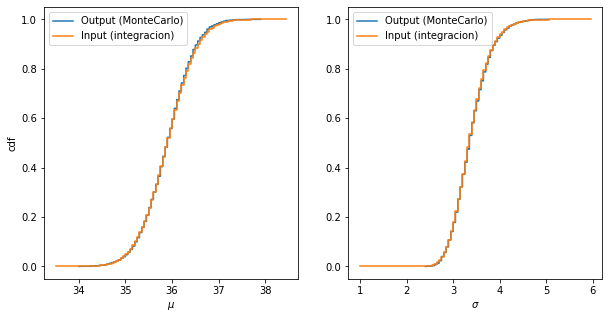

In [22]:
# Funciones acumuladas de la simulacion
ecdfs = ECDF(si)
ecdfmu = ECDF(mui)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot( 1, 2, 2)
ax.step(ecdfs.x,ecdfs.y,label='Output (MonteCarlo)')
ax.step(yvec,CDFs,label='Input (integracion)')
ax.set_xlabel(r'$\sigma$')
ax.legend()

ax = fig.add_subplot( 1, 2, 1)
ax.step(ecdfmu.x,ecdfmu.y,label='Output (MonteCarlo)')
ax.step(xvec,CDFmu,label='Input (integracion)')
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'cdf')
ax.legend()
plt.show()

Los pasos intermedios de la simulación son razonables. Veamos entonces el histograma que obtuvimos para las valores de resistencia en el hormigón $\tilde{y}$, y su función de probabilidad acumulada.

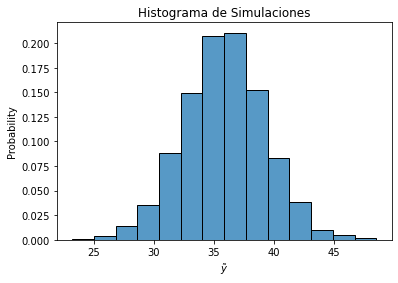

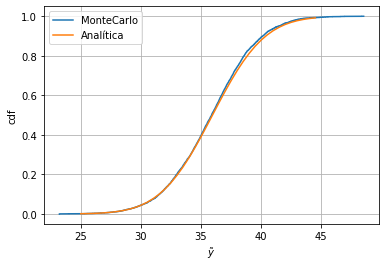

In [23]:
# Histograma con Seaborn
sns.histplot(data = yi, bins='sturges', stat='probability').set(title='Histograma de Simulaciones')
plt.xlabel(r'$\tilde{y}$')
plt.show()

# Función acumulada empírica
ecdfy = ECDF(yi)
plt.figure()
plt.step(ecdfy.x,ecdfy.y,label='MonteCarlo')
plt.plot(ytilde,y_post.cdf(ytilde),label='Analítica')
plt.xlabel(r'$\tilde{y}$')
plt.ylabel(r'cdf')
plt.legend()
plt.grid()
plt.show()

Se ve claramente que la simulación de Monte Carlo está convergiendo a la solución analítica que estabamos esperando (poder hacer esta comparación es un lujo, pero vale la pena para asegurarnos que sabemos aplicar la metodología en un ejemplo "sencillo").

####PASO 5: Evaluación (Ver por su cuenta)

Lo que faltaría ahora, al igual que en la clase anterior, es ver si el modelo propuesto (que condujo a un conjunto de valores simulados) se ajusta a los datos recibidos que llevaron a la inferencia de los parámetros.

Nuevamente usaremos para esto un qq-plot, con la salvedad de que esta ahora comparará dos soluciones empíricas: la de los datos reales medidos y la de los datos simulados en nuestro modelo. Más allá de eso su intepretación sigue siendo la misma.

El principal conflicto es que no hay una librería en Python que lo dibuje, hay que armarlo a mano. Abajo hay una función que creamos que arma el QQ-plot por ustedes. 

La función qqplot(x,y) asume que x son los datos simulados por Monte Carlo, e y los datos reales (debiera ser el vector más chico de los dos)

In [24]:
def qqplot(x,y):
# FUNCION PARA GRAFICAR QQ-PLOTS
# x es el vector con los datos obtenidos mediante simulacion
# y es el vector con los datos muestras
# La funcion asume que el vector x tiene más elementos que el vector y

  from scipy.interpolate import interp1d
  from statsmodels.distributions.empirical_distribution import ECDF
  # Funciones acumuladas empíricas
  CDFx = ECDF(x)
  CDFy = ECDF(y)

  # Factores de Correccion
  Nx = len(CDFx.x)-1
  CDFx.y = CDFx.y*Nx/(Nx+1)
  Ny = len(CDFy.x)-1
  CDFy.y = CDFy.y*Ny/(Ny+1)

  # Interpolación lineal para CDFx
  CDFx_interp = interp1d(CDFx.y[1:],CDFx.x[1:])

  # Cuantiles de Y
  Qy = CDFy.x[1:]
  # Encontrar los cuantiles de de x asociados a los de y
  Qx = np.zeros(len(Qy))
  for i in range(len(Qy)):
    Qx[i] = CDFx_interp(CDFy.y[i+1])

  # Datos para el grafico
  xmin = np.min([np.min(Qx),np.min(Qy)]) 
  xmax = np.max([np.max(Qx),np.max(Qy)])

  # Plot
  fig = plt.figure(figsize=(5,5))
  plt.scatter(Qx,Qy)
  plt.plot([xmin,xmax],[xmin,xmax],'k-')
  plt.grid()
  plt.xlabel('Cuantiles Simulación')
  plt.ylabel('Cuantiles Muestras')
  plt.show()

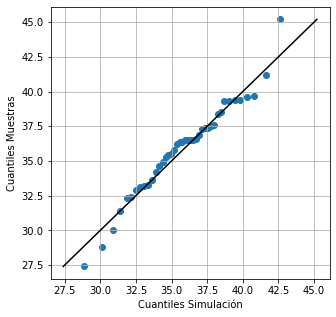

In [25]:
# Usar la función QQ-plot
qqplot(yi,df_probetas['Resistencia (MPa)'])

Como se puede ver, los ensayos simulados con Monte Carlo se ajustan muy bien a los datos reales, por lo que el modelo propuesto es apto.

Es más, pueden ver que el QQ-plot es virtualmente idéntico al que saldría de comparar las muestras con la función predictiva analítica.

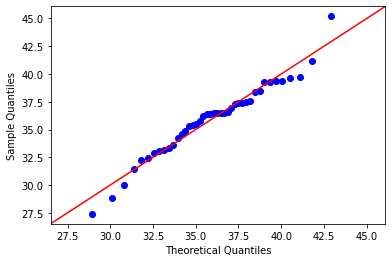

In [26]:
# QQ-plot con la solución analítica
fig = sm.qqplot(df_probetas['Resistencia (MPa)'], dist = y_post, line ='45')

####Paso 6: Aplicación (Ver por su cuenta)
Ya resuelto numéricamente el problema y habiendo validado el modelo, nada nos impide, por ejemplo, obtener la resistencia característica del hormigón. Recordando la definición:

$${f^{\prime}}_{c} = x\ /\ p(\tilde{y} | \mathbf{y} > x) = 0.9$$

¡Esto lo podemos buscar numéricamente simplemente con la CDF empírica que armamos! Buscando el valor más grande $\tilde{y}$ que tiene una probabilidad acumulada menor a 0.1 (para que la probabildiad de excedencia sea mayor a 0.9).

In [27]:
# Resistencia Caracteristica
fc = np.max(ecdfy.x[ecdfy.y<=0.1])
print('la resistencia caracteristica es',fc,'MPa')
print('la solución analítica era',y_post.ppf(0.1),'MPa')

la resistencia caracteristica es 31.52533328509938 MPa
la solución analítica era 31.513201646505706 MPa


Se obtiene una buena aproximación de la resistencia característica.

###Solución mediante Aproximación Cuadrática
Ahora vamos a resolver este mismo ejercicio pero mediante la aproximación cuadrática, es decir asumiendo que la función a posteriori resulta en un distribución normal (en este caso multivariada).

$$p(\mu,\sigma) \sim N(\mathbf{\theta},\Sigma)$$

####Paso 1: Definir la función a priori
En este ejercicio vamos a usar la misma de antes, que llamamos `prior`. Para hacer la optimización del método vamos a necesitar el logaritmo de la función a priori:

In [28]:
# Log-prior
logprior = lambda mu, s: np.log(s**(-1))

####Paso 2: Definir la función de verosimilitud
El siguiente paso es definir la función de verosimilitud, que va a ser la misma del ejercicio anterior. En este caso para la optimización vamos a usar la log-verosimilitud:


In [29]:
# Log-likelihood
logL = lambda mu, s: np.sum(st.norm.logpdf( df_probetas['Resistencia (MPa)'],
                                           loc = mu, scale = s))

####Paso 3: Encontrar las distribuciones posteriores
Con lo anterior ya podemos pasar a la estimación de los valores medios de los parámetros buscando el máximo de la distribución a posterior.

En realidad, lo que vamos a hacer es encontrar el mínimo del logaritmo de la distribución posterior cambiada de signo, ya que la mayoría de los algoritmos son de minimización y sabiendo que:

$$log\ p(\mu, \sigma|\mathbf{y}) = C + log\ p(\mathbf{y}|\mu,\sigma) + \log p(\mu, \sigma)$$

Al mismo tiempo, estimando la curvatura en el máximo podemos encontrar las varianzas de la distribución posterior (asumiendo una distribución normal multivariada)

Como comentario, como hay que utilizar un método de optimización, es recomendable probar distintos valores semillas para evaluar la sensibilidad de los resultados a estos. No siempre tenemos el beneficio de conocer el gráfico al que queremos llegar como en este caso.

In [30]:
# Log-posterior no normalizada
logposterior = lambda x: - logL( x[0], x[1] ) - logprior( x[0], x[1] )

# Aproximación cuadrática
x0 = np.array([0.9*muy,0.9*sy]) # Valores semilla de mu, sigma
opt = minimize( logposterior, x0, method='L-BFGS-B',
                options={'ftol': 1e-15, 'disp': True} ) # Optimización
pi = opt.x # Lugar donde la logverosimilitud es maxima
v = opt.hess_inv.todense() # Estimación de la curvatura en el máximo

# Dsitrbución conjunta por aproximación cuadrática
posterior_quap = st.multivariate_normal( mean=pi, cov=v )
pos = np.dstack((xgrid, ygrid))

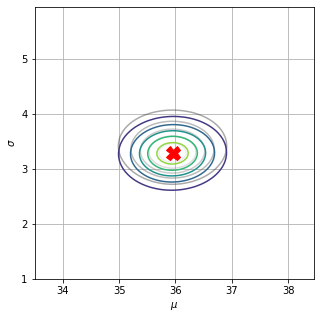

In [31]:
# Plot
pos = np.dstack((xgrid, ygrid))
fig, ax = plt.subplots( figsize=(5,5) )
ax.contour(xgrid, ygrid, posterior, cmap='gray', alpha=0.4)
ax.contour(xgrid, ygrid, posterior_quap.pdf( pos ), cmap='viridis')
ax.plot( pi[0], pi[1], 'rX', markersize=14 )
ax.grid()
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\sigma$');
plt.show()

¡Un éxito! En las curvas de nivel se ve que la aproximación como normal multivariada funciona bastante bien, aunque no puede captar la asimetría de la distribución a posteriori "real" con respecto a $\sigma$. Con los datos de la covarianza podemos a su vez obtener las distribuciones marginales de los parámetros:

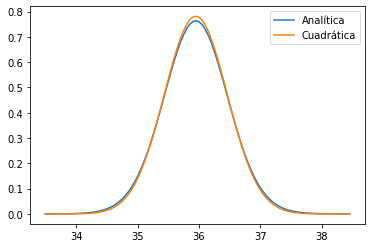

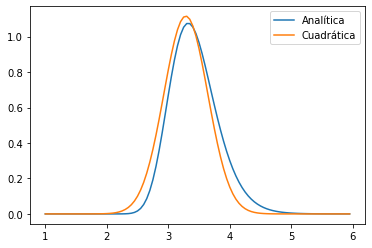

In [32]:
# Distribuciones marginales
mu_post_quap = st.norm( loc=pi[0], scale=np.sqrt(v[0,0]) )
s_post_quap = st.norm( loc=pi[1], scale=np.sqrt(v[1,1]) )

# Plot
fig, ax = plt.subplots()
ax.plot( xvec, mu_post.pdf(xvec), label='Analítica' )
ax.plot( xvec, mu_post_quap.pdf(xvec), label='Cuadrática' )
ax.legend();
plt.show()

fig, ax = plt.subplots()
ax.plot( yvec, 2*yvec*s2_post.pdf(yvec**2), label='Analítica' )
ax.plot( yvec,s_post_quap.pdf(yvec), label='Cuadrática' )
ax.legend();
plt.show()

Vean como se obtiene una muy buena aproximación para el valor medio (que sigue un t-student, similar a una distribución normal), mientras que la aproximación de la distribución posterior del desvío es más bruta, ya que la función normal no puede copiar la asimetría.

####Paso 4: Predicción mediante el método de Monte Carlo

Habiendo en contrado las distribuciones posteriores de los parámetros, podemos encontrar también la función predictiva. A esta altura contamos de distintas variantes según el problema. Podríamos buscar la solución análitica, podríamos resolver mediante integración numérica, podríamos realizar simulaciones de los parámetros y luego de las observaciones para obtener las probabilidades en forma empírica (Monte Carlo).

A modo de ejemplo nomás, veamos este último caso. Los pasos a seguir son:

1. Generar pares aleatorios de $\mu, \sigma$ con las funciones de scipy (ventajas de haber utilizado la aproximación cuadrática y haber ajustado una función normal multivariada)
2. para esos pares aleatorios de $\mu, \sigma$, simular una variable $\tilde{y}$ sabiendo que el modelo de generación de datos en normal dados los parámetros.

In [33]:
# Set de variables random
N = 5000 # Numero de muestras
theta_ran = posterior_quap.rvs(N)

# Empezar las simulaciones. Iterar por todas las muestras
si2 = np.zeros(N)
mui2 = np.zeros(N)
yi2 = np.zeros(N)
for i in range(N):
 si2[i] = theta_ran[i][1]
 mui2[i] = theta_ran[i][0]
 yi2[i] = st.norm.rvs(loc = mui2[i], scale = si2[i])

¡Y ya está! Bastante más fácil que el problema anterior. Veamos si estamos obteniendo algo lógico.

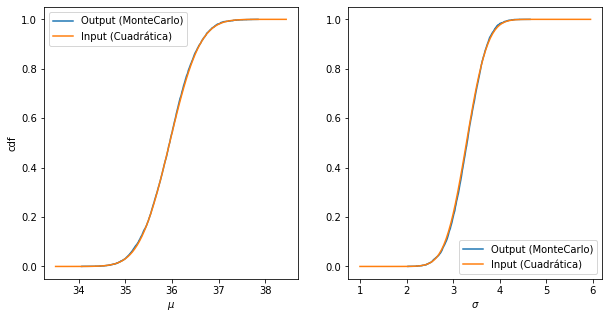

In [34]:
# Funciones acumuladas de la simulacion
ecdfs = ECDF(si2)
ecdfmu = ECDF(mui2)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot( 1, 2, 2)
ax.step(ecdfs.x,ecdfs.y,label='Output (MonteCarlo)')
ax.plot( yvec, s_post_quap.cdf(yvec), label='Input (Cuadrática)' )
ax.set_xlabel(r'$\sigma$')
ax.legend()

ax = fig.add_subplot( 1, 2, 1)
ax.step(ecdfmu.x,ecdfmu.y,label='Output (MonteCarlo)')
ax.plot( xvec, mu_post_quap.cdf(xvec), label='Input (Cuadrática)' )
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'cdf')
ax.legend()
plt.show()

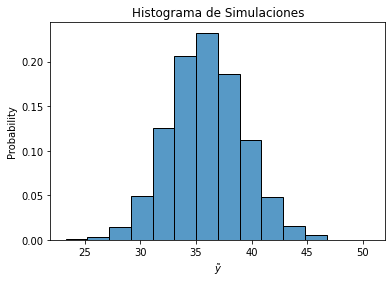

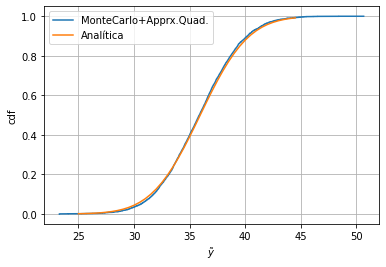

In [35]:
# Histograma con Seaborn
sns.histplot(data = yi2, bins='sturges', stat='probability').set(title='Histograma de Simulaciones')
plt.xlabel(r'$\tilde{y}$')
plt.show()

# Función acumulada empírica
ecdfy = ECDF(yi2)
plt.figure()
plt.step(ecdfy.x,ecdfy.y,label='MonteCarlo+Apprx.Quad.')
plt.plot(ytilde,y_post.cdf(ytilde),label='Analítica')
plt.xlabel(r'$\tilde{y}$')
plt.ylabel(r'cdf')
plt.legend()
plt.grid()
plt.show()

OK, los resultados de la simulación se corresponden con las distribuciones posteriores que usé, y el histograma de predicciones se ve razonable.

####Paso 5: Evaluación
Al igual que antes, haremos uso de un QQ-plot para ver si la distribución de las predicciones es consistente con los datos observados.

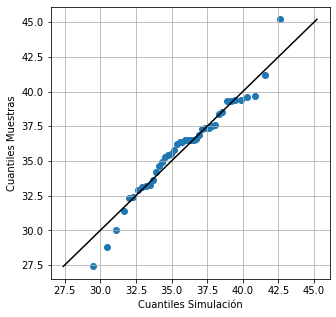

In [36]:
# Usar la función QQ-plot
qqplot(yi2,df_probetas['Resistencia (MPa)'])

El resultado sigue siendo muy bueno. Es más, la diferencia es casi imperceptible con el gráfico de qq-plot de la clase anterior y mismo del ejercicio resuelto más arriba.

Para este tipo de problemas donde hay baja asimetría y la distribución posterior se asemeja a una normal multivariada este método es muy útil.

####Paso 6: Aplicación
Ya resuelto numéricamente el problema y habiendo validado el modelo, nada nos impide, por ejemplo, obtener la resistencia característica del hormigón. Recordando la definición:

$${f^{\prime}}_{c} = x\ /\ p(\tilde{y} | \mathbf{y} > x) = 0.9$$

¡Esto lo podemos buscar numéricamente simplemente con la CDF empírica que armamos! Buscando el valor más grande $\tilde{y}$ que tiene una probabilidad acumulada menor a 0.1 (para que la probabildiad de excedencia sea mayor a 0.9).


In [37]:
# Resistencia Caracteristica
fc = np.max(ecdfy.x[ecdfy.y<=0.1])
print('la resistencia caracteristica es',fc,'MPa')
print('la solución analítica era',y_post.ppf(0.1),'MPa')

la resistencia caracteristica es 31.755886783805792 MPa
la solución analítica era 31.513201646505706 MPa


Se obtiene una buena aproximación de la resistencia característica.

###Solución mediante el método MCMC
Finalmente, resolvamos el ejercicio de nuevo pero utilizando Monte Carlo via cadenas de Markov. Los pasos a grandes rasgos son los mismos de antes, por lo que vamos a agruparlos todos.

Primero, veamos cómo trabajar con PyMC, una librería básicamente diseñada para este tipo de problemas. 

Se empieza por definir un modelo en el que se cargan las funciones de distribución a priori y la función de verosimilitud (que en la mayoría de los casos será igual a nuestro modelo de generación de datos y el fénomeno que queremos predecir). Luego, con la función `sample` se realiza la inferencia mediante cadenas de Markov.

In [38]:
# Simulación (PyMC3)
with pm.Model() as model:
    # Prior
    mumc = pm.Uniform('mu', 20, 60 )
    sigmamc = pm.Uniform('sigma', 0, 8 )
    # Verosimilitud
    ymc = pm.Normal('y', mu=mumc, sigma=sigmamc, observed=df_probetas['Resistencia (MPa)'])
    # Inferencia por Cadenas de Markov
    trace = pm.sample(1000, tune=1000, cores=2, return_inferencedata=True)

Una gran ventaja de PyMC es que tiene numerosas funciones que nos permiten evaluar nuestro modelo y extraer información. Por ejemplo creando gráficos y tablas resumen de los resultados

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,35.961,0.520,35.041,36.992,0.012,0.009,1847.0,1164.0,1.0
sigma,3.453,0.388,2.725,4.176,0.009,0.007,1756.0,1476.0,1.0


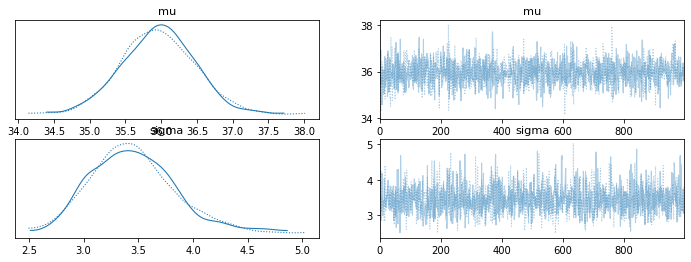

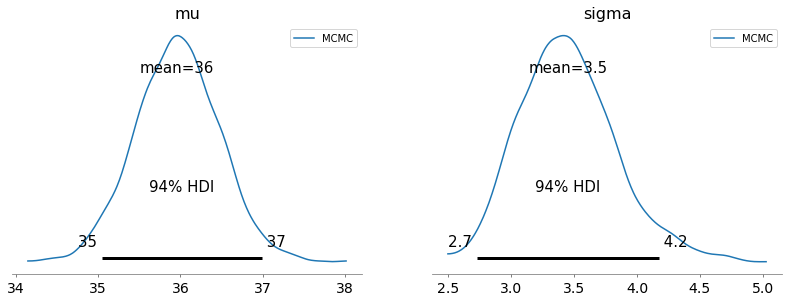

In [39]:
# MCMC diagnostic

# Ploteo de las simulaciones de la cadena
az.plot_trace(trace);
# Ploteo de las distribuciones posteriores con intervalos de confianza
az.plot_posterior(trace, label='MCMC');
# Tabla resumen de los resultados de la inferencia
az.summary(trace)

¡Nada nos impide igual comparar con un QQ-plot, todos los datos los podemos encontrar dentro de `trace`! Veamos como se comparan las simulaciones de $\mu,\sigma$ con la solución analítica.

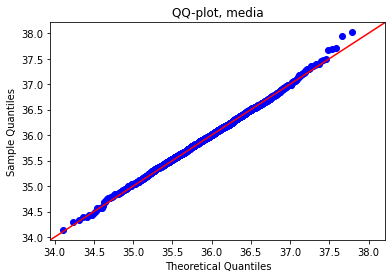

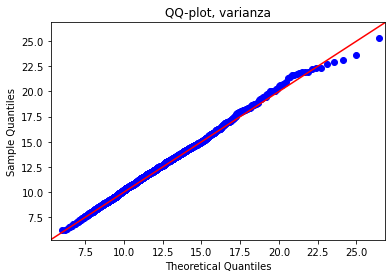

In [40]:
# Datos de mu de las cadenas de Markov
muData = trace['posterior']['mu'].values
muData = muData.reshape(-1)

#qqplot
fig = sm.qqplot(muData, dist = mu_post, line ='45')
plt.title('QQ-plot, media')
plt.show()

# Datos de sigma de las cadenas de Markov
sData = trace['posterior']['sigma'].values
sData = sData.reshape(-1)

#qqplot
fig = sm.qqplot(sData**2, dist = s2_post, line ='45')
plt.title('QQ-plot, varianza')
plt.show()

Evaluar la función predictiva es también bastante simple:

In [41]:
with model:
    post_pred = pm.sample_posterior_predictive(trace)

Esto genera 2000 realizaciones (1000 por cadena) de muestras de igual tamaño que la muestra que introdujimos como dato (es decir, nos queda de 2000 x 42)

In [42]:
print(post_pred['posterior_predictive']['y'].shape)

(2, 1000, 42)


PyMC3 entonces nos permite ver la variabilidad de los resultados. Por ejemplo, dibujando las 2000 campanas que resultan de simular 42 ensayos de hormigón con cada combinación de $\mu,\sigma$ de la cadena de Markov, así como la camapana promedio de todas las realizaciones.

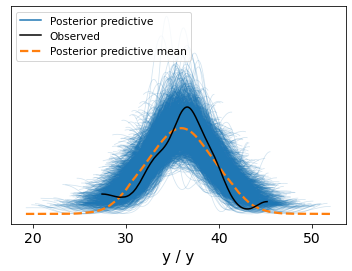

In [43]:
az.plot_ppc(post_pred);

También podemos, por nuestra cuenta, hacer los gráficos de QQ-plot tomando 1000 muestras. Los resultados no debieran ser sensibles a cuál de los 42 datos tomo para cada muestra.

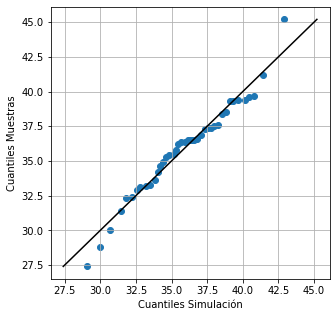

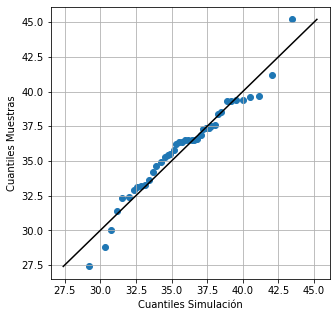

In [44]:
# Tomando el ensayo 1 de cada realización
qqplot(post_pred['posterior_predictive']['y'][0,:,0],df_probetas['Resistencia (MPa)'])

# Tomando el ensayo 33 de cada realización
qqplot(post_pred['posterior_predictive']['y'][0,:,32],df_probetas['Resistencia (MPa)'])

Como se puede ver los resultados son casi idénticos y hay un buen ajuste entre los datos observados y los simulados por nuestro modelo. Luego el problema sigue como el anterior, con las simulaciones podemos calcular probabilidades por conteo.

## Ejemplo 2: Mediciones con distintos equipos

El modelo que explica los resultados de un ensayo (asumiendo que nuestros ensayos no tienen errores sistemáticos) es:
$$
y = z + ɛ,\ z \sim N(\mu,\sigma^2),\ \varepsilon\sim N(0,\sigma_o^2)\\
y \sim N \left( \mu, \sigma^2 + \sigma_o^2 \right)
$$

Donde $\sigma^2$ es la varianza inherente de la magnitud medida, mientras que ${\sigma_o}^2$ es la varianza correspondiente a la precisión del instrumento de medición.

En este ejercicio vamos a ver como inferir los parámetros de un modelo el cual no podemos observar directamente (el desvío propio del proceso física se ve escondido detrás de la imprecisión de nuestros equipos de medición). A su vez, vamos a ver cómo afecta la combinación de ensayos de distinta calidad en nuestra inferencia.

Se tienen mediciones de una magnitud física con 2 métodos con distinta precisión conocida. Se conoce la precisión de cada instrumento y busca determinarse la distribución posterior de la magnitud física.
- Equipo 1: precisión $\sigma_{o1}=3$, se tienen 10 ensayos
- Equipo 2: precisión $\sigma_{o2}=0.2$, se tienen 3 ensayos

El objetivo es ver si hacer ensayos con el Equipo 2 teniendo ensayos del Equipo 1 reduce la incertidumbre en nuestra estimación y viceversa.

Abajo está la creación de un dataset simulado:

In [45]:
np.random.seed(220922)
# VALORES REALES DE LA MAGNITUD A ENSAYAR
mu = 15
s = 1

# PRECISION DE LOS SENSORES
s1 = 3
s2 = 0.2

# NUMERO DE ENSAYOS CON CADA SENSOR
N1 = 10
N2 = 3

# SIMULACION DE LOS ENSAYOS
y_1 = st.norm.rvs( size=N1, loc=mu, scale=np.sqrt(s**2+s1**2) )
y_2 = st.norm.rvs( size=N2, loc=mu, scale=np.sqrt(s**2+s2**2) )

El siguiente paso es encontrar las distribuciones posteriores de los parámetros del modelo de generación de datos (es decir, $\mu,\sigma$ de la magnitud física.

###Inferencia considerando los equipos por separado

Primero, cálcule la distribución de los parámetros considerando sólo los datos del Equipo 1 o los del Equipo 2. Puede usar, por ejemplo, cadenas de Markov. Este problema no tiene solución análitica por más sencillo que parezca.

Tenga cuidado al definir distribuciones a priori de que sean poco-informativas y que $\sigma$ pueda tomar únicamente valores positivos. La función de verosimilitud en este caso será igual al modelo de generación de datos.

####Equipo 1

In [46]:
with pm.Model() as model_norm:
    # Definir distribuciones a priori 'mu', 'sigma'

    # CODIGO DEL ALUMNO ========================================================
    mu = pm.Normal('mu',mu = np.mean(y_1),sigma = 100)
    sigma = pm.HalfNormal('sigma', sigma=10)
    # ==========================================================================
    
    # Definir función de verosimilitud (son 2, para y_1 e y_2) 'norm1'

    # CODIGO DEL ALUMNO ========================================================
    norm1 = pm.Normal('norm1', mu=mu, sigma=np.sqrt(sigma**2+s1**2), observed=y_1)
    # ==========================================================================
    
    # Distribución posterior
    trace2 = pm.sample( 5000, chains=2, tune=2000,target_accept=0.95 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,16.672,1.053,14.737,18.671,0.015,0.011,4968.0,5098.0,1.0
sigma,1.105,0.902,0.001,2.687,0.013,0.009,3537.0,3021.0,1.0


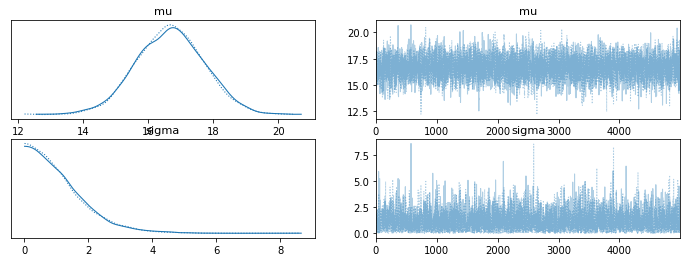

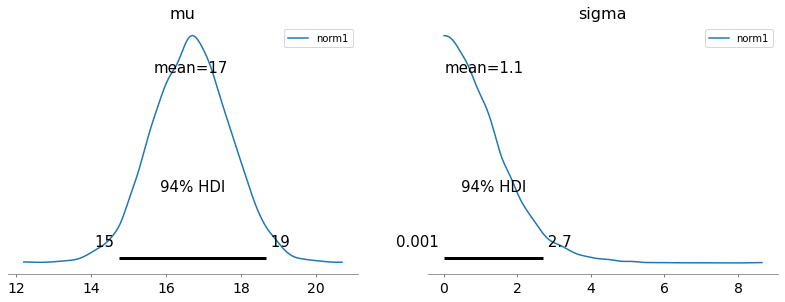

In [47]:
# MCMC diagnostic
az.plot_trace(trace2)
az.plot_posterior(trace2, label='norm1');
az.summary(trace2)

####Equipo 2

In [48]:
with pm.Model() as model_norm:
    # Definir distribuciones a priori 'mu', 'sigma'

    # CODIGO DEL ALUMNO ========================================================
    mu = pm.Normal('mu',mu = np.mean(y_2),sigma = 100)
    sigma = pm.HalfNormal('sigma', sigma=10)
    # ==========================================================================
    
    # Definir función de verosimilitud (son 2, para y_1 e y_2)

    # CODIGO DEL ALUMNO ========================================================
    norm2 = pm.Normal('norm2', mu=mu, sigma=np.sqrt(sigma**2+s2**2), observed=y_2)
    # ==========================================================================
    
    # Distribución posterior
    trace = pm.sample( 5000, chains=2, tune=2000,target_accept=0.95 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,15.346,2.317,11.015,19.274,0.070,0.049,1799.0,1302.0,1.0
sigma,3.112,2.626,0.503,7.767,0.066,0.047,1833.0,2251.0,1.0


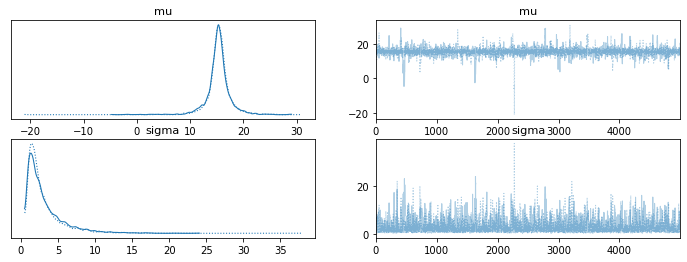

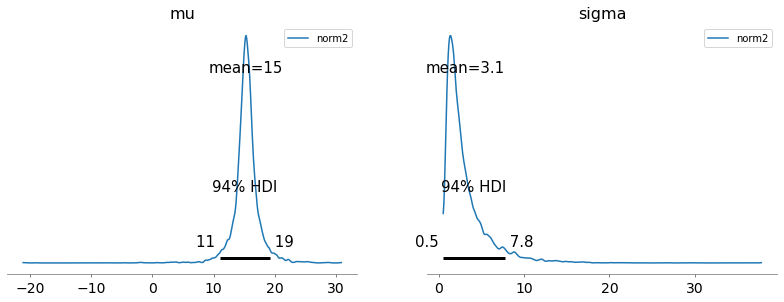

In [49]:
# MCMC diagnostic
az.plot_trace(trace)
az.plot_posterior(trace, label='norm2');
az.summary(trace)

###Inferencia considerando todos los ensayos

Ahora haga los mismo pero juntado ambos ensayos. Para ello pueden usar, por ejemplo, cadenas de markov. Tenga mucho cuidado al definir la función de verosimilud, ya que la expresión cambia según el dato provenga del Equipo 1 o del Equipo 2.

$$p(y_{i}|\mu ,\sigma ) = \begin{cases} p\left(y=y_{i}|\mu, \sqrt{\sigma^{2} + {\sigma _{01}}^{2}}\right) & y_{i}\ \in Equipo\ 1 \\ p\left(y=y_{i}|\mu, \sqrt{\sigma^{2} + {\sigma _{02}}^{2}}\right) & y_{i}\ \in Equipo\ 2 \end{cases}$$

entonces:

$$\log\ L = \sum_{y_{i1}} \log p\left(y=y_{i}|\mu, \sqrt{\sigma^{2} + {\sigma _{01}}^{2}}\right) + \sum_{y_{i2}} \log p\left(y=y_{i}|\mu, \sqrt{\sigma^{2} + {\sigma _{02}}^{2}}\right)$$

En PyMC, esto se puede resolver escribiendo 2 funciones de verosimilitud: una para los datos provenientes del Equipo 1 y otra para los datos provenientes del Equipo 2. La librería luego se ocupa de hacer la suma de las log-verosimilitudes

In [50]:
with pm.Model() as model_norm:
    # Definir distribuciones a priori 'mu', 'beta'

    # CODIGO DEL ALUMNO ========================================================
    mu = pm.Normal('mu',mu = (N1*np.mean(y_1)+N2*np.mean(y_2))/(N1+N2),sigma = 100)
    sigma = pm.HalfNormal('sigma', sigma=10)
    # ==========================================================================
    
    # Definir función de verosimilitud (son 2, para y_1 e y_2), `norm1` y `norm2`

    # CODIGO DEL ALUMNO ========================================================
    norm1 = pm.Normal('norm1', mu=mu, sigma=np.sqrt(sigma**2+s1**2), observed=y_1)
    norm2 = pm.Normal('norm2', mu=mu, sigma=np.sqrt(sigma**2+s2**2), observed=y_2)
    # ==========================================================================
    
    # Distribución posterior
    trace3 = pm.sample( 5000, chains=2, tune=2000,target_accept=0.95 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,15.845,0.696,14.584,17.184,0.011,0.008,4181.0,3673.0,1.0
sigma,1.476,0.624,0.577,2.595,0.010,0.008,3765.0,5138.0,1.0


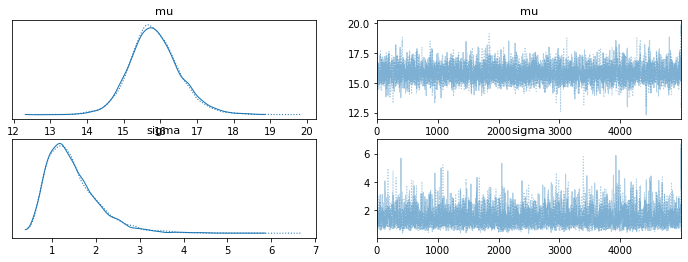

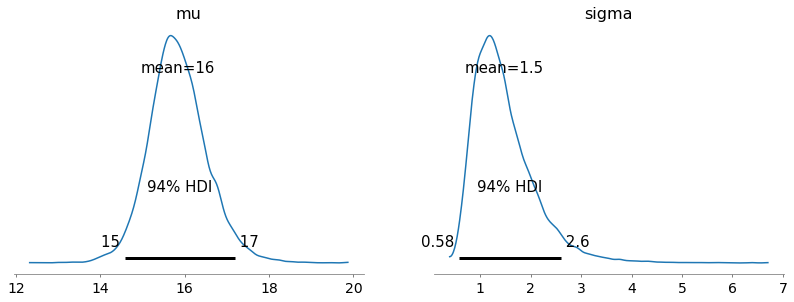

In [51]:
# MCMC diagnostic
az.plot_trace(trace3)
az.plot_posterior(trace3);
az.summary(trace3)

###Comparación entre análisis

Abajo pueden ver la comparación entre la distribución de los parámetros según si se analiza los datos del Equipo 1 (10 ensayos), los del Equipo 2 (3 ensayos), o el conjunto de ensayos en su totalidad.

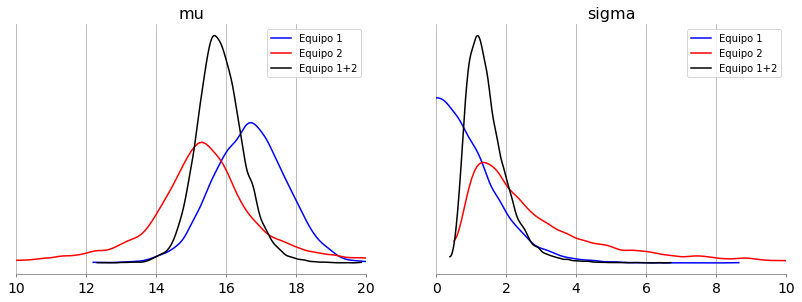

In [52]:
b = az.plot_posterior(trace2,hdi_prob='hide',point_estimate=None,color='b',label='Equipo 1')
az.plot_posterior(trace,ax=b,hdi_prob='hide',point_estimate=None,color='r',label='Equipo 2')
az.plot_posterior(trace3,ax=b,hdi_prob='hide',point_estimate=None,color='k',label='Equipo 1+2')
b[0].set_xlim([10,20])
b[0].grid()
b[1].set_xlim([0,10])
b[1].grid()

plt.show()

En base a lo visto se pueden sacar algunas conclusiones:

1. La inferencia con el Equipo 1 tiene mayor incertidumbre que aquella realizada con el Equipo 2, aunque del primero se realizaron 10 ensayos y en el otro sólamente 3. Esto parece contraintuitivo ya que siempre decimos a más datos menos incertibumbre, pero en realidad tiene sentido. El ruido extra metido por el sensor hace que los datos sean de peor calidad, lo que hace más díficil una inferencia certera de los datos
2.  La moda de la distribución de los parámetros usando los datos de los 2 equipos se parece más a la moda con el Equipo 2 que a la del 1. Esto es otra vez debido al ruido. Si lo piensan en términos de la función de verosimilud, la verosimilitud de los puntos medidos con el Equipo 2 es más puntiaguda, por lo que sus valores tienen más peso a la hora de definir los valores más probables, aunque haya menos datos totales.
3. Si se tienen los datos del Equipo 1, aún hacer unos pocos ensayos con el Equipo 2 se justifica debido a la mayor calidad de los datos.
4. Si se tienen los datos del Equipo 2 hacer ensayos baratos y de baja calidad también aporta a la estimación al reducir la incertidumbre de los datos por efecto de la cantidad! Obviamente lo mejor sería tener 13 ensayos del Equipo 2, pero el costo sería prohibitivo.
5. Una pregunta interesante es si hay una combinación óptima de ensayos dado un límite presupuestario. ¡Eso se los dejamos para que prueben! 

##Ejemplo 3: Mediciones de aceleraciones saturadas (ver por su cuenta)

En este tercer ejemplo vamos a resolver un problema para el cual no existe solución analítica, por lo que nos veremos obligados a utilizar alguno de los métodos numéricos vistos anteriormente.

Nosotros tenemos un dataset de de vibraciones medidas durante la demolición de un puente en la Ciudad de Buenos Aires. La teoría de vibraciones aleatorias nos dice que el ruido se comporta como un ruido blanco es decir que la aceleración en un instante $t$ es una variable aleatoria y que vibración en el tiempo no está correlacionada, por lo que son eventos independientes idénticamente distribuidos. En general se asume que es un proceso Gaussiano.

$$acc_{t} \sim N(\mu=0,\sigma=\bar{\sigma})$$

Para este ejercicio, por razones que no vamos a discutir en detalle, se adoptó un modelo t-Student que se determinó reflejaba mejor los datos:

$$acc_{t} \sim t_{11.5}(\mu=0,\sigma=\bar{\sigma})$$

En resumen, un registro de más de 20000 datos de aceleración (ruido) se lo puede analizar sin considerar las particularidades de las series temporales. Cada instante es una realización de la V.A. independiente e identicamente distribuido.

No es lo ideal, pero a veces una incorrecta configuración del sensor puede resultar en pérdida de información. El caso más común es que la amplitud de las vibraciones sea mayor al rango medible por el sensor, provocando la saturación de los resultados.

Veamos el caso de nuestro dataset.

###Paso 1: Carga de los datos y análisis exploratorio

In [53]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving vibraciones_demolicion.csv to vibraciones_demolicion (1).csv


In [54]:
#Se crea un DataFrame
df_vib = pd.read_csv(io.BytesIO(uploaded['vibraciones_demolicion.csv']))
df_vib.head()

,time,acc,atrunc
0,0.000000,-0.002607,-0.002607
1,0.004202,0.014793,0.014793
2,0.008403,0.012393,0.012393
3,0.012605,0.011193,0.011193
4,0.016807,0.012993,0.012993


Tenemos 2 registros, uno de un acelerómetro que no saturó y otro que estaba seteado para medir aceleraciones de hasta $0.02m/s^{2}$. Si uno mira el registro de este último estaría tentado a descartar la medición.

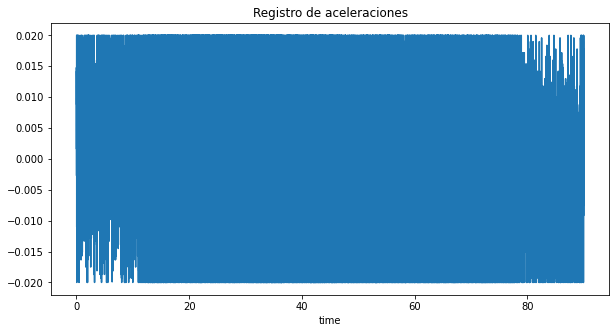

In [55]:
# Grafico
df_vib.plot(x='time', y='atrunc', legend=False, figsize=(10,5))
plt.title('Registro de aceleraciones')
plt.show()

Se ve claramente que el registro satura en 0.02 y -0.02, lo que en primera medida parece haber destrozado el ensayo ¡Sin embargo tiene mucha más información de lo que parece!

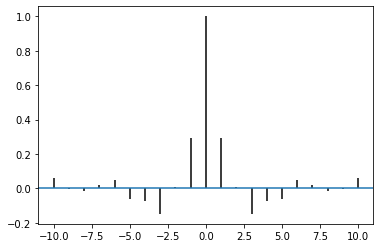

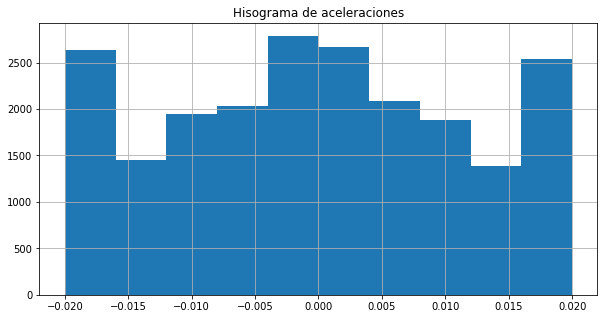

In [56]:
# Autocorrelación
plt.acorr( df_vib['atrunc']-df_vib['atrunc'].mean() )
plt.show()

# Histograma
df_vib['atrunc'].hist(figsize=(10,5))
plt.title('Hisograma de aceleraciones')
plt.show()

Por un lado podemos ver que los datos están no correlacionados. A su vez, parece distinguirse el histograma de una VA normal o t-Student, pero con los valores de las colas todos acumulados en los límites del acelerómetro. Lo que vamos a hacer hoy es tratar de "salvar" el dataset y descubrir el fenómeno físico atrás de nuestras mediciones imperfectas.

####NOTA ANEXA: Un poco de trampa - el caso no saturado

Veamos qué se ve en el caso no saturado:

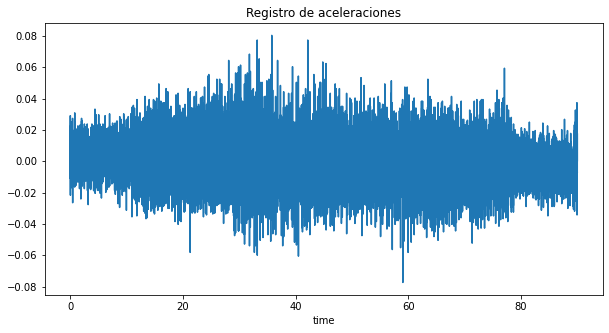

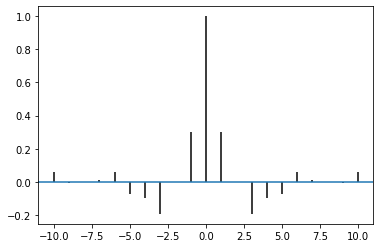

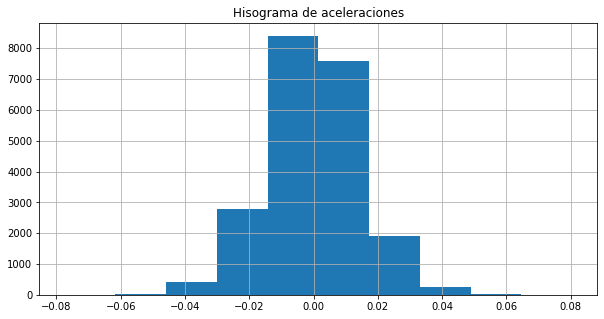

In [57]:
# Grafico
df_vib.plot(x='time', y='acc', legend=False, figsize=(10,5))
plt.title('Registro de aceleraciones')
plt.show()

# Autocorrelación
plt.acorr( df_vib['acc']-df_vib['acc'].mean() )
plt.show()

# Histograma
df_vib['acc'].hist(figsize=(10,5))
plt.title('Hisograma de aceleraciones')
plt.show()

Resolvamos el problema de encontrar $\sigma$ usando la aproximación cuadrática.

[0.01301873]


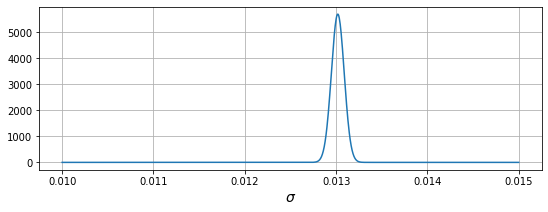

In [58]:
# Log-prior
logprior = lambda s:  st.expon.logpdf(s,scale=0.01)

# Log-likelihood
logL = lambda s: np.sum(st.t.logpdf(df_vib['acc'] , 11.5, scale = s))

# Log-posterior no normalizada
logposterior = lambda x: - logL(x) - logprior(x)

# Aproximación cuadrática
x0 = [0.01] # Valores semilla de sigma
opt = minimize( logposterior, x0, method='L-BFGS-B',
                options={'ftol': 1e-5, 'disp': True} ) # Optimización
pi = opt.x # Lugar donde la logverosimilitud es maxima
v = opt.hess_inv.todense() # Estimación de la curvatura en el máximo

# Dsitrbución por aproximación cuadrática
posterior_quaps = st.norm( loc=pi[0], scale=np.sqrt(v[0,0]) )

print(pi)

# Dsitrbución por aproximación cuadrática
posterior_quap = st.norm( loc=pi[0], scale=np.sqrt(v[0,0]) )

# Plot
x=np.linspace(0.01,0.015,1001)
fig = plt.figure(figsize=(9,3))
plt.plot(x,posterior_quap.pdf(x).reshape(-1),label='no saturado')
plt.grid()
plt.xlabel(r'$\sigma$',fontsize=14)
plt.show()

Este resultado vamos a usarlo para poder comparar después con el caso saturado.

###Paso 2: Elegir un método de solución
En este caso vamos a usar una aproximación cuadrática, ya que vimos antes que salvo que haya asimetrías importantes esperadas funciona bastante bien.

###Paso 3: Proponer una distribución a priori para $\sigma$

Si a fin de cuentas estamos resolviendo un problema de V.A. t-student con grado de libertad conocido, es probable que tenga sentido adoptar como distribución no informativa algo del estilo:

In [59]:
# Log-prior
logprior = lambda s: st.expon.logpdf(s,scale=0.01)

###Paso 4: Definir la función de verosimilitud
Este es el paso crítico del ejericio. Nosotros tenemos que los datos son generados por una variable aleatoria t-Student. En principio entonces uno diría que la verosimilitud va a ser el producto de distribuciones.

Sin embargo nosotros tenemos en realidad 3 casos. La probabilidad de que el acelómetro informe $0.2$ es muchísimo mayor, porque todo valor real mayor a $0.2$ es truncado. lo mismo pasa en el otro umbral. Entonces, en el tramo que no se ve afectado por el truncamiento la verosimilitud va a ser efectivamente aquella dada por la distribución t-Student, pero en los límites de la muestra sera la probabilidad acumulada de superar los umbrales!

$$p(\mathbf{y} | \sigma) = \prod_{i=1}^{N} p(y_{i}| \sigma)$$

con

$$ p(y_{i}|\sigma) = \begin{cases} p(y_{i}|\sigma) & if -0.02 < y_{i} <0.02\\ p(Y\leq -0.02|\sigma) & if\ y_{i}\leq -0.02\\ 1-p(Y\leq 0.02|\sigma) & if\ y_{i}\geq 0.02 \end{cases}$$

Para la optimización nosotros trabajaremos con el logaritmo, que convierte al producto en una sumatoria. En realidad terminaremos con tres sumatorias, ya que según el valor de $y_{i}$ tendremos que usar una expresión u otra para el cálculo de $p(y_{i}|\sigma)$

¡Veamos cómo se ve!



In [60]:
thre = 0.02

N = len(df_vib['acc'])
# Log-likelihood

# Observaciones en cota inferior
Filter1 = df_vib['acc']<=-thre
viblow = df_vib['acc'][Filter1]
print(len(viblow))

# Observaciones en cota superior
Filter2 = df_vib['acc']>= thre
vibhigh = df_vib['acc'][Filter2]
print(len(vibhigh))

# Observaciones dentro del rango
Filter3 = (df_vib['acc']>-thre) * (df_vib['acc']<thre)
vibmid = df_vib['acc'][Filter3]
print(len(vibmid))

print(len(viblow)+len(vibhigh)+len(vibmid),N)

# Log-likelihood
logL = lambda s: np.sum(st.t.logpdf(vibmid,11.5,loc=0,scale=s)) + st.t.logcdf(-thre,11.5,loc=0,scale=s)*len(viblow) + st.t.logsf(thre,11.5,loc=0,scale=s)*len(vibhigh)

1595
1691
18134
21420 21420


###Paso 5: Estimar la distribucion posterior
Ahora, con todo listo, realizamos la optimización para encontrar el valor más probable de $\sigma$ y la curvatura.



In [61]:
# Log-posterior no normalizada
logposterior = lambda x: - logL(x) - logprior(x)

# Aproximación cuadrática
x0 = 0.01 # Valores semilla de sigma
opt = minimize( logposterior, x0, method='L-BFGS-B',
                options={'ftol': 1e-5, 'disp': True} ) # Optimización
pi = opt.x # Lugar donde la logverosimilitud es maxima
v = opt.hess_inv.todense() # Estimación de la curvatura en el máximo

print(pi)

# Dsitrbución por aproximación cuadrática
posterior_quap2 = st.norm( loc=pi[0], scale=np.sqrt(v[0,0]) )

[0.0130136]


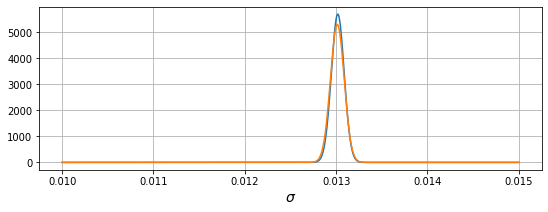

In [62]:
# Plot
x=np.linspace(0.010,0.015,1001)
fig = plt.figure(figsize=(9,3))
plt.plot(x,posterior_quap.pdf(x).reshape(-1),label='no saturado')
plt.plot(x,posterior_quap2.pdf(x).reshape(-1),label='saturado')
plt.grid()
plt.xlabel(r'$\sigma$',fontsize=14)
plt.show()

Fijensé lo que obtuvimos: la función de distribución de $\sigma$ es muy similar para el caso saturado que para el caso no saturado. Esto implica que el modelo es muy bueno (Hint: Si resuelven esto con un modelo Normal no les va a pasar).

La forma más correcta de definir el modelo de generación de datos es tener 2 variables, los grados de libertad $\nu$ y la escala $\sigma$ de la t-Student. Luego, al dataset saturado se lo puede ir saturando aún más y ver si el resultado de la inferencia es robusto a este cambio!

Ese proceso lleva MUCHO tiempo, por eso les mostramos el resultado con el grado de libertad de la t-Student ya definido, y resolviendo solo para el caso que nos importa.

###Paso 6: Evaluación

Ahora ya podemos obtener muestras de de aceleración mediante Monte Carlo. Y aunque lo único que podemos comparar realmente es nuestras vibraciones saturadas con la simulación de un acelerómetro simulado, para este ejemplo vamos a mostrar el potencial de nuestro modelo.

Lo que vamos a hacer es simular NO un acelerómetro que satura, sino el verdadero fenómeno detrás, y con un poco de trampa vamos a comparar con el acelerómetro no saturado.

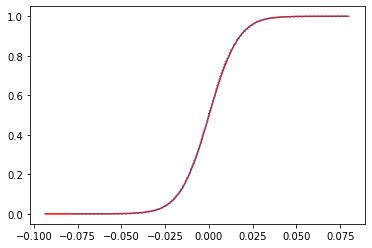

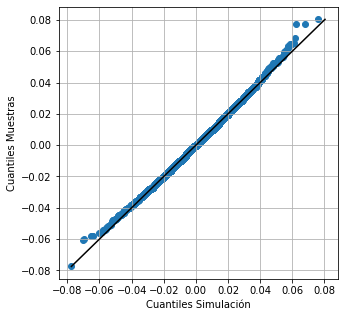

In [63]:
# Set de variables random
N = 50000 # Numero de muestras
theta_ran = posterior_quap2.rvs(N)

# Empezar las simulaciones. Iterar por todas las muestras
n2 = np.zeros(N)
s2 = np.zeros(N)
yi2 = np.zeros(N)
for i in range(N):
 s2[i] = theta_ran[i]
 yi2[i] = st.t.rvs(11.5,loc = 0, scale = s2[i])

# Plot
edfy = ECDF(yi2)
edff = ECDF(df_vib['acc'])
plt.plot(edfy.x,edfy.y,'r-')
plt.plot(edff.x,edff.y,':')
plt.show()

# QQ-plot
qqplot(yi2,df_vib['acc'])

Fijensé que da excelente!

###ALTERNATIVA: Solución por Cadenas de Markov

El ejemplo anterior se puede resolver también mediante MCMC. Presten atención a cómo se carga el modelo que es bastante particular

In [64]:
# Simulación (PyMC3)
with pm.Model() as model:
    # Prior
    scalemc = pm.HalfNormal('sigma',sigma=100)

    # Likelihood
    realy = pm.StudentT.dist(nu=11.5, sigma=scalemc)
    ymc = pm.Censored('y',dist=realy,lower=-0.02,upper=0.02,observed=df_vib['atrunc'])

    # Inferencia por Cadenas de Markov
    trace = pm.sample(2000, tune=2000, cores=2, return_inferencedata=True)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.013,0.0,0.013,0.013,0.0,0.0,1811.0,2824.0,1.0


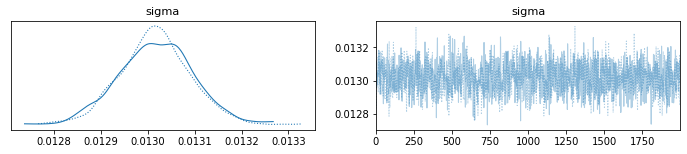

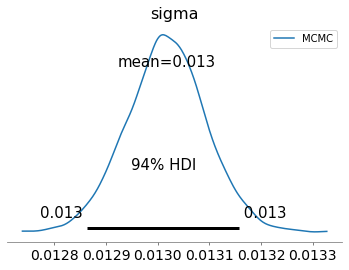

In [65]:
# MCMC diagnostic
# Ploteo de las simulaciones de la cadena
az.plot_trace(trace);
# Ploteo de las distribuciones posteriores con intervalos de confianza
az.plot_posterior(trace, label='MCMC');
# Tabla resumen de los resultados de la inferencia
az.summary(trace)

Nos dio igual que antes! Luego puedo pasar a simular variables como hicimos en el ejemplo anterior, la cadena de Markov ya nos da todas las simulaciones de los parámetros, así que queda en nosostros simular para cada uno de ellos el valor de aceleración que toma al final.

Les mostramos abajo también la solución por cadenas de Markov para el caso no saturado:

In [66]:
# Simulación (PyMC3)
with pm.Model() as model:
    # Prior
    scalemc = pm.Uniform('sigma', 0, 0.1)

    # Likelihood
    ymc = pm.StudentT('y',nu=11.5,sigma=scalemc,observed=df_vib['acc'])

    # Inferencia por Cadenas de Markov
    trace = pm.sample(2000, tune=2000, cores=2, return_inferencedata=True)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.013,0.0,0.013,0.013,0.0,0.0,2157.0,2472.0,1.0


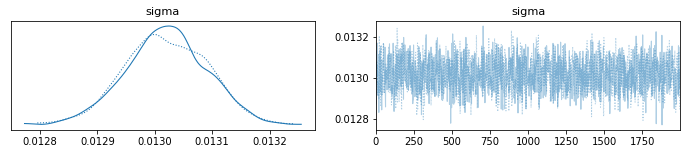

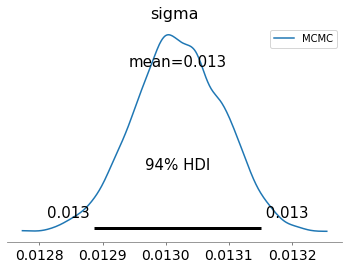

In [67]:
# MCMC diagnostic
# Ploteo de las simulaciones de la cadena
az.plot_trace(trace);
# Ploteo de las distribuciones posteriores con intervalos de confianza
az.plot_posterior(trace, label='MCMC');
# Tabla resumen de los resultados de la inferencia
az.summary(trace)

Nuevamente, dio igual! Esto es porque elegimos muy bien el modelo de generación de datos.

####NOTA ANEXA: Qué pasaba con el modelo normal?

Abajo pueden ver que pasa si resuelvo con cadenas de Markov usando un modelo de generación normal:

In [68]:
# Simulación (PyMC3)
with pm.Model() as model:
    # Prior
    scalemc = pm.Uniform('sigma', 0, 0.1)

    # Likelihood
    realy = pm.Normal.dist(mu=0, sigma=scalemc)
    ymc = pm.Censored('y',dist=realy,lower=-0.02,upper=0.02,observed=df_vib['atrunc'])

    # Inferencia por Cadenas de Markov
    trace = pm.sample(2000, tune=2000, cores=2, return_inferencedata=True)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.014,0.0,0.014,0.014,0.0,0.0,1759.0,2695.0,1.0


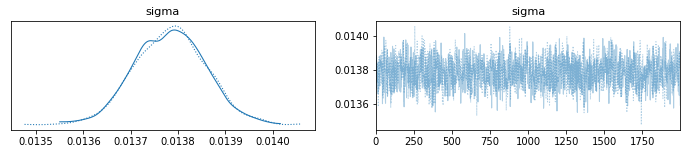

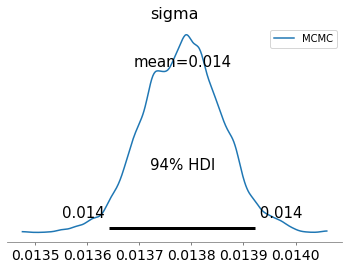

In [69]:
# MCMC diagnostic
# Ploteo de las simulaciones de la cadena
az.plot_trace(trace);
# Ploteo de las distribuciones posteriores con intervalos de confianza
az.plot_posterior(trace, label='MCMC');
# Tabla resumen de los resultados de la inferencia
az.summary(trace)

In [70]:
# Simulación (PyMC3)
with pm.Model() as model:
    # Prior
    scalemc = pm.Uniform('sigma', 0, 0.1)

    # Likelihood
    ymc = pm.Normal('y',mu=0,sigma=scalemc,observed=df_vib['acc'])

    # Inferencia por Cadenas de Markov
    trace = pm.sample(2000, tune=2000, cores=2, return_inferencedata=True)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.014,0.0,0.014,0.014,0.0,0.0,1597.0,2630.0,1.0


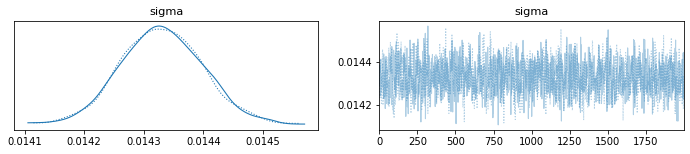

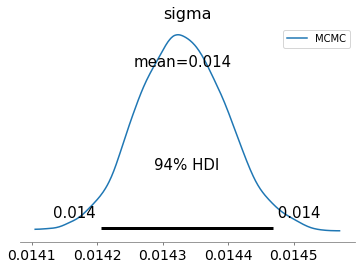

In [71]:
# MCMC diagnostic
# Ploteo de las simulaciones de la cadena
az.plot_trace(trace);
# Ploteo de las distribuciones posteriores con intervalos de confianza
az.plot_posterior(trace, label='MCMC');
# Tabla resumen de los resultados de la inferencia
az.summary(trace)

La inferencia depende del truncamiento! Esto es porque el modelo de generación de datos elegido no es bueno para este problema. Una forma fácil de ver por qué es estudiando la kurtosis de las aceleraciones no saturadas:

In [72]:
print(df_vib['acc'].kurtosis())

0.7710543172059219


Una VA Normal tiene Kurtosis 0! por lo que nunca va a ajustar bien las colas de mis datos, que en este problema son claves por el efecto de la saturación.

La t-student adoptada en este ejercicio puede adaptarse mucho mejor a esto. Como dijimos antes, el $\nu$ de la t-Student se puede incorporar como otro parámetro a estimar en forma bayesiana, lo que vuelve al modelo mucho más complejo.

#Apéndice: Compendio de funciones y código genérico

## Aproximación por grilla

In [73]:
def posterior_grid_approx( prior, likelihood, grid_points=100 ):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior_grid = prior( p_grid )

    # compute likelihood at each point in the grid
    likelihood_grid = likelihood( p_grid )

    # compute product of likelihood and prior
    unstd_posterior = likelihood_grid * prior_grid

    # standardize the posterior, so it sums to 1
    C = 1 / np.trapz( x=p_grid, y=unstd_posterior )
    posterior = C * unstd_posterior 
    return p_grid, prior_grid, likelihood_grid, posterior

### Modelo Beta-Bernoulli (1D)

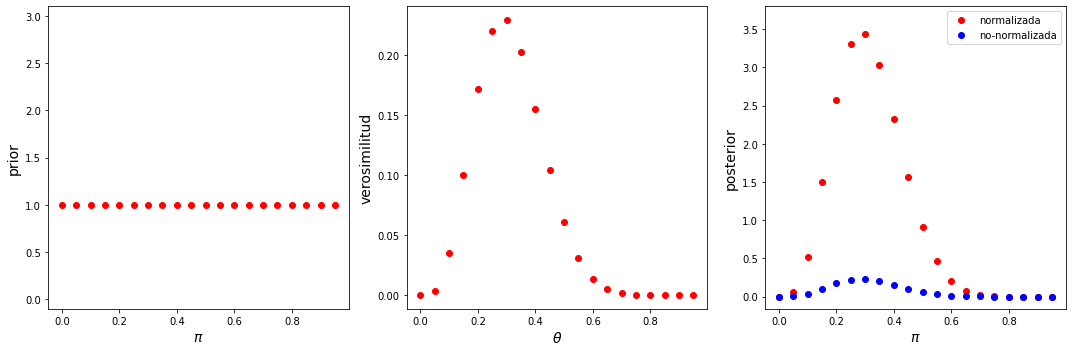

In [74]:
T = 4 # exitos
N = 14 # total intentos

prior = lambda x: st.beta.pdf( x, a=1, b=1 ) # uniforme(0,1)
likelihood = lambda x: st.binom.pmf( T, N, x )

# define grid
dx = 0.05
p_grid = np.arange(0, 1, dx)

# define prior
prior_grid = prior( p_grid )

# compute likelihood at each point in the grid
likelihood_grid = likelihood( p_grid )

# compute product of likelihood and prior
unstd_posterior = likelihood_grid * prior_grid

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / (unstd_posterior.sum()*dx)

# Plot
fig, ax = plt.subplots( figsize=(15,5), nrows=1, ncols=3 )
ax[0].plot(p_grid, prior_grid, 'ro')
ax[0].set_xlabel(r'$\pi$', fontsize=14)
ax[0].set_ylabel('prior', fontsize=14)

ax[1].plot(p_grid, likelihood_grid, 'ro')
ax[1].set_xlabel(r'$\theta$', fontsize=14)
ax[1].set_ylabel('verosimilitud', fontsize=14)

ax[2].plot(p_grid, posterior, 'ro', label='normalizada')
ax[2].plot(p_grid, prior_grid*likelihood_grid, 'bo', label='no-normalizada')
ax[2].set_xlabel(r'$\pi$', fontsize=14)
ax[2].set_ylabel('posterior', fontsize=14)
ax[2].legend()

# ax[2].plot( p_grid, st.beta.pdf( p_grid, a=5+T, b=1.5+A ) )
ax[0].set_ylim( bottom=-0.1, top=3.1 )
ax[2].set_ylim( bottom=-0.16, top=3.8 )

fig.tight_layout()

### Modelo Normal - Normal-GammaInvesa (2D)

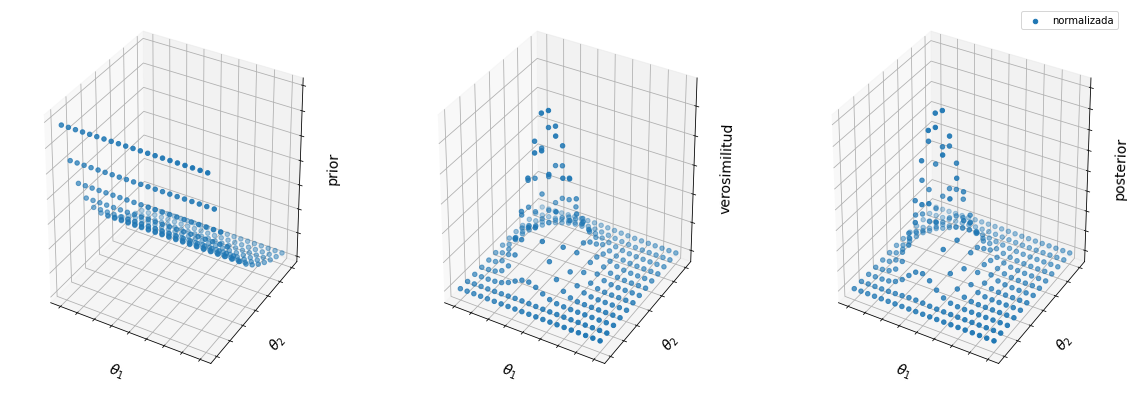

In [75]:
N = 30
data = st.norm.rvs( size=N, loc=5, scale=1.5 )

# Non-informative prior
prior = lambda x, y: y**(-2)
# prior = lambda x, y: st.norm.pdf( x, loc=5, scale=4 ) * st.invgamma.pdf( y, 1, 1 )

def likelihood( data, x, y ):
    l = np.zeros( x.shape )
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            l[i,j] = np.sum( st.norm.logpdf( data, loc=x[i,j], scale=y[i,j] ) )
    return np.exp(l)

# Definir grilla
dx = 0.1
dy = 0.1
xgrid, ygrid = np.meshgrid( np.arange(4,6.1,dx), np.arange(0.8,2.1,dy) )

# Definir priori
prior_grid = prior( xgrid, ygrid )

# Calcular verosimilitud
likelihood_grid = likelihood( data, xgrid, ygrid )

# Calcular posterior no-normalizada
unstd_posterior = likelihood_grid * prior_grid

# Normalizar posterior
posterior = unstd_posterior/(unstd_posterior.sum()*dx*dy)

# Theoretical posterior
posterior_th = 0

# Plot
fig = plt.figure( figsize=(20,7) )

ax = fig.add_subplot( 1, 3, 1, projection='3d' )
ax.scatter( xgrid, ygrid, prior_grid )
ax.set_xlabel(r'$\theta_1$', fontsize=14)
ax.set_ylabel(r'$\theta_2$', fontsize=14)
ax.set_zlabel('prior', fontsize=14)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax = fig.add_subplot( 1, 3, 2, projection='3d' )
ax.scatter( xgrid, ygrid, likelihood_grid )
ax.set_xlabel(r'$\theta_1$', fontsize=14)
ax.set_ylabel(r'$\theta_2$', fontsize=14)
ax.set_zlabel('verosimilitud', fontsize=14)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter( xgrid, ygrid, posterior, label='normalizada')
ax.set_xlabel(r'$\theta_1$', fontsize=14)
ax.set_ylabel(r'$\theta_2$', fontsize=14)
ax.set_zlabel('posterior', fontsize=14)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.legend();

## Aproximación cuadrática

### Modelo Beta-Bernoulli

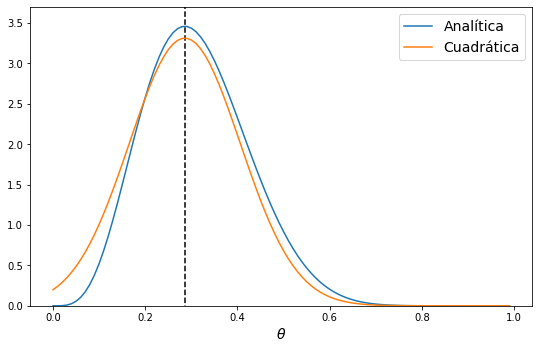

In [76]:
from scipy.optimize import minimize

T = 4
N = 14

# Hyper-parameters
a = 1; b = 1 # Uniforme(0,1)
prior = lambda x: st.beta.pdf( x, a=a, b=b )
likelihood = lambda x: st.binom.pmf( T, N, x )
un_posterior = lambda x: -prior(x) * likelihood(x)
un_logposterior = lambda x: - np.log(prior(x)) - np.log(likelihood(x))
posterior = lambda x: st.beta.pdf( x, a=T+a, b=N-T+b) # analítica

# MAP estimate
x0 = 0.5
opt = minimize( un_logposterior, x0, method='L-BFGS-B', bounds=((0.01,1),),
                options={'ftol': 1e-5, 'disp': True} )
piMAP = opt.x[0]
vMAP = opt.hess_inv.todense()[0]
posterior_quap = st.norm( loc=piMAP, scale=np.sqrt(vMAP) )

# PLOT
xplot = np.arange( 0, 1, 0.01 )
fig, ax = plt.subplots( figsize=(9,5.5) )
ax.plot( xplot, posterior( xplot ), label='Analítica' )
ax.plot( xplot, posterior_quap.pdf(xplot), label='Cuadrática' )
ax.vlines( x=piMAP, ymin=-10, ymax=100, linestyle='--', color='k' )
ax.set_ylim([0,3.7])
ax.set_xlabel(r'$\theta$', fontsize=14)
ax.legend( fontsize=14 );

### Modelo Normal - Normal-GammaInversa

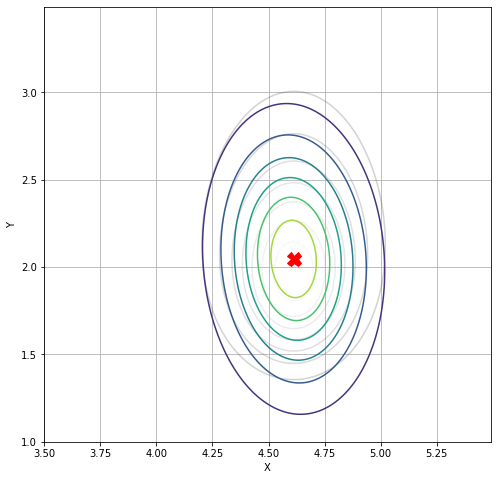

In [77]:
# Observations
np.random.seed(1234)
mu=4.5
sigma = 1.5
N = 50
y = st.norm.rvs( size=N, loc=mu, scale=sigma )
muy = y.mean()
sy = y.std()
xgrid, ygrid = np.meshgrid( np.arange(3.5,5.5,0.01), np.arange(1,3.5,0.01) )
pos = np.dstack((xgrid, ygrid))

# Log-prior
logprior = lambda mu, s2: s2**(-1)

# Log-Likelihood
loglikelihood = lambda mu, s2: np.sum( st.norm.logpdf( y, loc=mu, scale=np.sqrt(s2) ) )

def likelihood_grid( x, y ):
    l = np.zeros( x.shape )
    for i in range(x.shape[0]):
        for j in range(xgrid.shape[1]):
            l[i,j] = loglikelihood( x[i,j], y[i,j] )
    return np.exp(l)

# Posterior conjugada
s2_cond_y_post = st.invgamma( a=(N-1)/2, scale=(N-1)*sy**2/2 )
# Conditional posterior of mean given observations and standard deviation
mu_cond_s2_y_post = lambda s2: st.norm( loc=muy, scale=np.sqrt( s2/N ) )
# Log-posterior no normalizada
un_logposterior = lambda x: - loglikelihood( x[0], x[1] ) - logprior( x[0], x[1] )
# Posterior analítica
posterior = lambda mu, s2: s2_cond_y_post.pdf( s2 ) * mu_cond_s2_y_post( s2 ).pdf( mu )

# Aproximación cuadrática
x0 = np.array([3.75,3])
xii = np.array([x0[0],x0[1]])
opt = minimize( un_logposterior, x0, method='L-BFGS-B',
                options={'ftol': 1e-5, 'disp': True} )
piMAP = opt.x
vMAP = opt.hess_inv.todense()
posterior_quap = st.multivariate_normal( mean=piMAP, cov=vMAP )
pos = np.dstack((xgrid, ygrid))

fig, ax = plt.subplots( figsize=(8,8) )
ax.contour(xgrid, ygrid, posterior( xgrid, ygrid ), cmap='gray', alpha=0.2)
# ax.plot( xii[:,0], xii[:,1], color='b', marker='s', markersize=12 )
# ax.plot( xii[0,0], xii[0,1], color='r', marker='s', markersize=12 )
ax.contour(xgrid, ygrid, posterior_quap.pdf( pos ), cmap='viridis')
ax.plot( piMAP[0], piMAP[1], 'rX', markersize=14 )
ax.grid()
ax.set_xlabel('X')
ax.set_ylabel('Y');

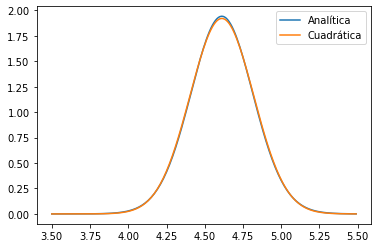

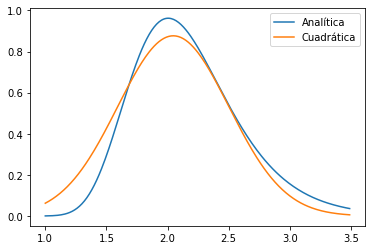

In [78]:
# Marginales
mu_post_analytic = st.t( N-1, loc=muy, scale=sy*np.sqrt(1/N) )
mu_post_quap = st.norm( loc=piMAP[0], scale=np.sqrt(vMAP[0,0]) )
s2_post_quap = st.norm( loc=piMAP[1], scale=np.sqrt(vMAP[1,1]) )


# Plot
mu_plot = np.unique( xgrid )
s2_plot = np.unique( ygrid )

fig, ax = plt.subplots()
ax.plot( mu_plot, mu_post_analytic.pdf(mu_plot), label='Analítica' )
ax.plot( mu_plot, mu_post_quap.pdf(mu_plot), label='Cuadrática' )
ax.legend();

fig, ax = plt.subplots()
ax.plot( s2_plot, s2_cond_y_post.pdf(s2_plot), label='Analítica' )
ax.plot( s2_plot, s2_post_quap.pdf(s2_plot), label='Cuadrática' )
ax.legend();

## MCMC

### Modelo Beta-Bernoulli

Mi primer cadena de MCMC!!!

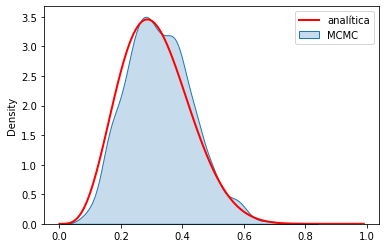

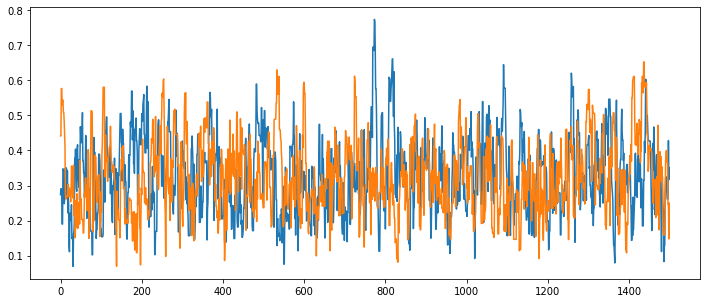

In [79]:
T = 4
N = 14

# Hyper-parameters
a = 1; b = 1 # Uniforme(0,1)
prior = lambda x: st.beta.pdf( x, a=a, b=b )
likelihood = lambda x: st.binom.pmf( T, N, x )
un_posterior = lambda x: prior(x) * likelihood(x)
un_logposterior = lambda x: - np.log(prior(x)) - np.log(likelihood(x))
posterior = lambda x: st.beta.pdf( x, a=T+a, b=N-T+b) # analítica

# MCMC chain parameters
target = un_posterior
step = 0.1
Nsim = 3000
Nchains = 2
x0 = 0.03

accepted = np.zeros([Nchains,Nsim])
accepted[0] = x0
proposal = np.zeros([Nchains,Nsim])
proposal[0] = x0
for j in range(Nchains):
  for i in range(1,Nsim):
      # Proposal
      jump = st.norm( loc=x0, scale=step )
      proposal[j,i] = jump.rvs( size=1 )[0]
      # accept
      r = target( proposal[j,i] ) / target( x0 ) # symmetrical jump!
      if np.random.random() < r:
          x0 = proposal[j,i]
      else:
          x0 = x0
      # Update accepted
      accepted[j,i] = x0

# Burn-in
burnin = int(Nsim/2)
t_burnin = accepted[:,burnin:]
t_mcmc = t_burnin.flatten()

# Plot
xplot = np.arange( 0, 1, 0.01 )
fig, ax = plt.subplots()
ax.plot( xplot, posterior( xplot ), color='r', linewidth=2, label='analítica' )
sns.kdeplot( t_mcmc, fill=True, label='MCMC', ax=ax )
ax.legend()

# MCMC diagnostics
fig, ax = plt.subplots( figsize=(12,5) )
ax.plot( t_burnin.T, label='chains' );

Usando PyMC3

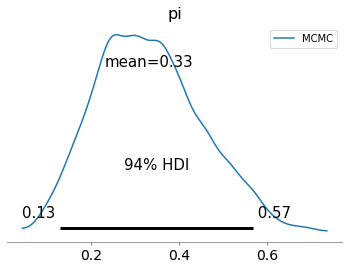

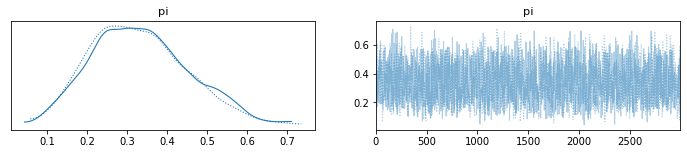

In [80]:
# !pip install pymc
import pymc as pm
import arviz as az

# Obsrevaciones binarias
y = np.array([0,0,1,0,0,0,1,1,0,1,0,0,0])

# Simulación (PyMC3)
with pm.Model() as model:
    # Prior
    pi = pm.Uniform('pi', lower=0, upper=1 )
    # Verosimilitud
    y = pm.Bernoulli('y', p=pi, observed=y)
    # MCMC
    trace = pm.sample(3000, tune=1000, cores=2, return_inferencedata=True)

# Plot posterior
xplot = np.arange( 0, 1, 0.01 )
fig, ax = plt.subplots()
# ax.plot( xplot, posterior( xplot ), color='r', linewidth=2, label='analítica' )
az.plot_posterior(trace, ax=ax, label='MCMC')
ax.legend();

# MCMC diagnostic
az.plot_trace(trace);

### Modelo Normal - Normal-GammaInversa

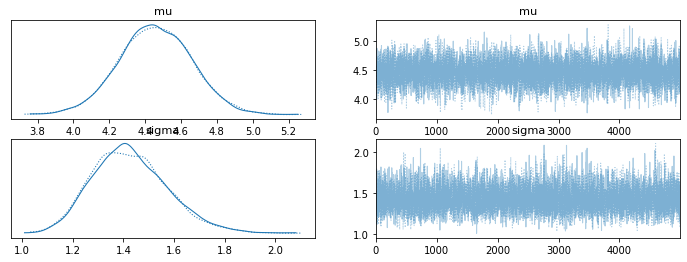

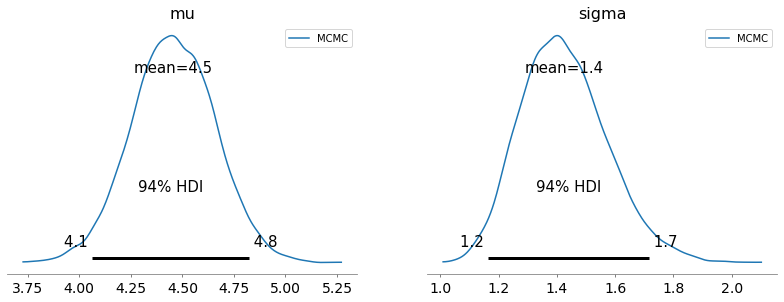

In [81]:
# Observaciones
mu = 4.5
sigma = 1.5
N = 50
y = st.norm.rvs( size=N, loc=mu, scale=sigma )
muy = y.mean()
sy = y.std()
xgrid, ygrid = np.meshgrid( np.arange(3.5,5.5,0.01), np.arange(1,3.5,0.01) )
pos = np.dstack((xgrid, ygrid))

# Simulación (PyMC3)
with pm.Model() as model:
    # Prior
    mu = pm.Normal('mu', mu=0, sigma=10 )
    sigma = pm.HalfNormal('sigma', sigma=2 )
    # Verosimilitud
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
    # MCMC
    trace = pm.sample(5000, tune=1000, cores=2, return_inferencedata=True)

# MCMC diagnostic
az.plot_trace(trace)
az.plot_posterior(trace, label='MCMC');

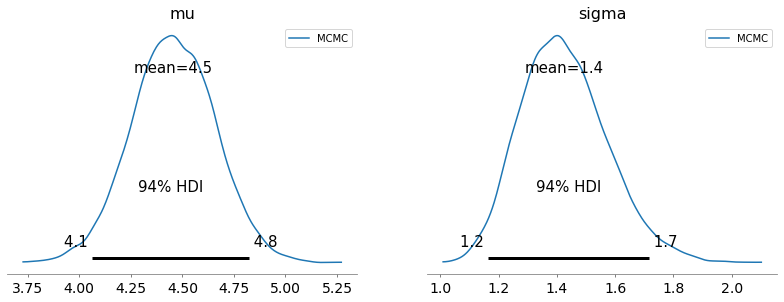

In [82]:
az.plot_posterior(trace, label='MCMC');
